In [1]:
import numpy as np
import random 
from datetime import datetime
from numpy import genfromtxt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

ModuleNotFoundError: No module named 'torch'

## Select S&P500 Dataset from Jan 4, 1960 to Apr 22, 2022
https://www.nasdaq.com/market-activity/index/spx/historical

In [2]:
price_1=pd.read_csv('HistoricalPrices1(1).csv')
price_2=pd.read_csv('HistoricalPrices2.csv')
price_3=pd.read_csv('HistoricalPrices3.csv')
# remove redundant variables
price_3 = price_3.drop(['Volume', 'Adj Close' ], 1)
# transform Date to date timestamp
price_3['Date'] = pd.to_datetime(price_3['Date'])
price_3 = price_3.loc[ (price_3['Date'] < '1978-01-03') &  (price_3['Date']  >= '1960-01-01' )]
price_2['Date'] = pd.to_datetime(price_2['Date'])
price_1['Date'] = pd.to_datetime(price_1['Date'])
#reverse the dataset
price_2 = price_2.iloc[::-1].reset_index(drop = True)
price_1 = price_1.iloc[::-1].reset_index(drop = True)
#reset the column names
price_2.columns = ['Date', 'Open', 'High', 'Low', 'Close']
price_1.columns = ['Date', 'Open', 'High', 'Low', 'Close']
# combine three s&p500 datasets
# now the dataset includes all the s&p 500 price data from 4 Jan 1960 to 11 Mar 2022 
frames = [price_3, price_2, price_1]
price = pd.concat(frames).reset_index(drop = True)
price

/var/folders/s2/fmmt4ytn7b5bzsjj332lc6dr0000gn/T/ipykernel_12010/1470519155.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  price_3 = price_3.drop(['Volume', 'Adj Close' ], 1)


Date         Open         High          Low        Close
0     1960-01-04    59.910000    59.910000    59.910000    59.910000
1     1960-01-05    60.389999    60.389999    60.389999    60.389999
2     1960-01-06    60.130001    60.130001    60.130001    60.130001
3     1960-01-07    59.689999    59.689999    59.689999    59.689999
4     1960-01-08    59.500000    59.500000    59.500000    59.500000
...          ...          ...          ...          ...          ...
15678 2022-04-18  4385.630000  4410.310000  4370.300000  4391.690000
15679 2022-04-19  4390.630000  4471.030000  4390.630000  4462.210000
15680 2022-04-20  4472.260000  4488.290000  4448.760000  4459.450000
15681 2022-04-21  4489.170000  4512.940000  4384.470000  4393.660000
15682 2022-04-22  4385.830000  4385.830000  4267.620000  4271.780000

[15683 rows x 5 columns]

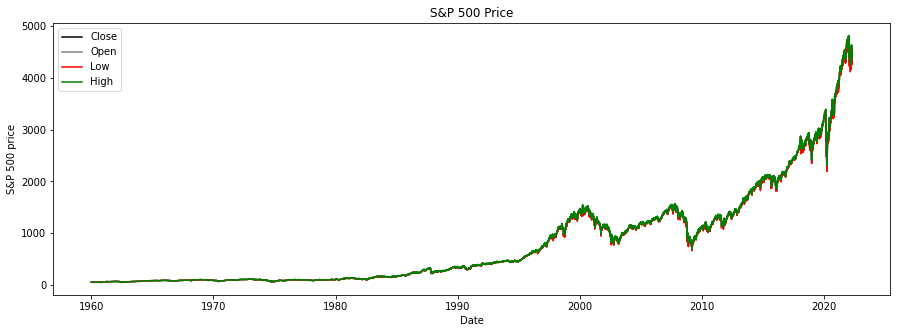

In [3]:
# show the graph
plt.figure(figsize=(15, 5));
plt.plot(price.Date, price.Close.values, color='black', label='Close')
plt.plot(price.Date, price.Open.values, color='grey', label='Open')
plt.plot(price.Date, price.Low.values, color='red', label='Low')
plt.plot(price.Date, price.High.values, color='green', label='High')
plt.title('S&P 500 Price')
plt.xlabel('Date')
plt.ylabel('S&P 500 price')
plt.legend(loc='best')
plt.show()

### Used Open, High, Low and Close data to train the model

In [4]:
dataset = price[['Open' , 'High' , 'Low' , 'Close']].values
dataset_original = dataset
dataset

array([[  59.91    ,   59.91    ,   59.91    ,   59.91    ],
       [  60.389999,   60.389999,   60.389999,   60.389999],
       [  60.130001,   60.130001,   60.130001,   60.130001],
       ...,
       [4472.26    , 4488.29    , 4448.76    , 4459.45    ],
       [4489.17    , 4512.94    , 4384.47    , 4393.66    ],
       [4385.83    , 4385.83    , 4267.62    , 4271.78    ]])

In [5]:
# extract the timestamp
date_data = price[['Date']].values
date_data

array([['1960-01-04T00:00:00.000000000'],
       ['1960-01-05T00:00:00.000000000'],
       ['1960-01-06T00:00:00.000000000'],
       ...,
       ['2022-04-20T00:00:00.000000000'],
       ['2022-04-21T00:00:00.000000000'],
       ['2022-04-22T00:00:00.000000000']], dtype='datetime64[ns]')

In [6]:
# scale the data by using MinMaxScalern 数据归一化 介于0-1之间
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.00162237, 0.00161757, 0.00181023, 0.00162509],
       [0.00172337, 0.00171827, 0.00191173, 0.00172626],
       [0.00166866, 0.00166372, 0.00185675, 0.00167146],
       ...,
       [0.93008663, 0.93069641, 0.92994254, 0.92894511],
       [0.9336449 , 0.93586801, 0.91634681, 0.91507811],
       [0.91189969, 0.9092002 , 0.89163595, 0.88938866]])

In [7]:
# number of timepoints and features
n_rows, n_cols = dataset.shape
(n_rows, n_cols)

(15683, 4)

In [8]:
# general settings
# the number of expected features in the input x is 2
input_size = 4

# output_size = 4 as we want to predict the next one, two, three, and four trading data 
output_size = 4

# sequence length is 180, for the sliding sampling window
window_size = 180

In [9]:
# Creating a data structure with 180 timesteps and 4 output 测试+训练 20% 80% 一年253个交易日
X_full = []
Y_full = []
date_full = []
for i in range( n_rows - window_size - output_size +1):
    X_full.append(dataset[i:i+window_size, ])
    Y_full.append(dataset[i+window_size: i+ window_size + output_size, 0])
    date_full.append(date_data[i+window_size])
    
X_full, Y_full, date_full = np.array(X_full), np.array(Y_full), np.array(date_full)
Y_full = np.reshape(Y_full, (Y_full.shape[0], 1, Y_full.shape[1]))

In [10]:
X_train = []; Y_train = []; date_train = []
X_test = []; Y_test = []; date_test = []

for i in range(X_full.shape[0]):
    if(i  %  253 >= 200):
        X_test.append(X_full[i])
        Y_test.append(Y_full[i])
        date_test.append(date_full[i])
    else:
        X_train.append(X_full[i])
        Y_train.append(Y_full[i])
        date_train.append(date_full[i])
X_train, Y_train, date_train = np.array(X_train), np.array(Y_train), np.array(date_train)          
X_test, Y_test, date_test = np.array(X_test), np.array(Y_test), np.array(date_test)      

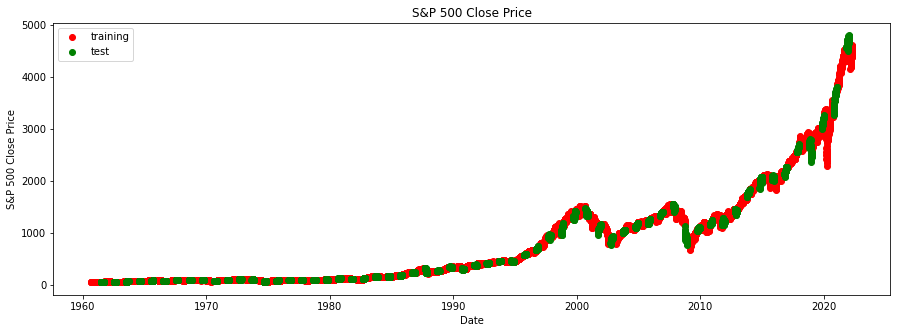

In [11]:
# Visualizing training dataset and test dataset 红色训练 蓝色测试 看哪些是~
out_temp = np.concatenate((Y_train[:, 0, [0]], 
                           Y_train[:, 0, [0]],
                           Y_train[:, 0, [0]],
                           Y_train[:, 0, [0]]), axis=1)
price_train = scaler.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate((Y_test[:, 0, [0]], 
                           Y_test[:, 0, [0]],
                           Y_test[:, 0, [0]],
                           Y_test[:, 0, [0]]), axis=1)
price_test = scaler.inverse_transform(out_temp)[:, [0]]

plt.figure(figsize=(15, 5));
plt.plot(date_train, price_train[:,0], color = 'red', label = 'training', marker= 'o', linestyle='None')
plt.plot(date_test, price_test[:,0], color = 'green', label = 'test', marker= 'o', linestyle='None')
plt.title('S&P 500 Close Price')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

## Design and develop a recurrent neural network (RNN) in Python.

In [12]:
class RNN (nn.Module):
    def __init__(self, input_size, output_size, hidden_size, n_layers):
        super(RNN, self).__init__()
        # Define parameters
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        # Define layers
        self.rnn = nn.RNN(input_size, hidden_size, n_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        # Initialize hidden state for the first input
        hidden = self.init_hidden(batch_size)
        # Transport the input and hidden state into the RNN and get output
        out, hidden = self.rnn(x, hidden)
        # Reshape output in order to be used for fully connected layer
        out = self.fc(out)
        # Return final output
        return out[:, -1, :], hidden

    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size)
        return hidden

In [13]:
# Other parameters for the RNN model
hidden_size = 16
n_layers = 1 #change
learning_rate = 0.001
rnn_1 = RNN(input_size, output_size, hidden_size, n_layers)
optimizer = torch.optim.Adam(rnn_1.parameters(), lr=learning_rate) #优化器用的adam 处理normalization的结果
criterion = nn.MSELoss() #损失函数 loss fun 用的MSEloss～

In [14]:
# The RNN model structure rnn给了16个给fc 通过fc江16个数据 池化成4个输出
rnn_1

RNN(
  (rnn): RNN(4, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=4, bias=True)
)

In [15]:
# Display parameters in the model 打印rnn1的各个参数
for name, param in rnn_1.named_parameters():
    print(name, param.data.shape)

rnn.weight_ih_l0 torch.Size([16, 4])
rnn.weight_hh_l0 torch.Size([16, 16])
rnn.bias_ih_l0 torch.Size([16])
rnn.bias_hh_l0 torch.Size([16])
fc.weight torch.Size([4, 16])
fc.bias torch.Size([4])


## Train RNN on Training Set (S&P500 data) then test to ensure it functions correctly when predicting the next one, two, three, and four trading data (close price).

In [16]:
loss_all_1 = []
for epoch in range(150):
    # make training sets in torch
    inputs = Variable(torch.from_numpy(X_train).float())
    labels = Variable(torch.from_numpy(Y_train).float())      #将数据格式转换
    # set zero gradients
    optimizer.zero_grad()
    # forward pass
    output, hidden = rnn_1(inputs) 
    # calculate loss
    loss = criterion(output.reshape(-1), labels.view(-1))
    loss_all_1 += [loss.item()]
    # Backward pass
    loss.backward(retain_graph=True)
    # print loss
    if (epoch % 10 == 0 ):
        print("Epoch ", epoch, "MSE: ", loss.item())
    # Update parameters
    optimizer.step()        

Epoch  0 MSE:  0.05602610483765602
Epoch  10 MSE:  0.029014024883508682
Epoch  20 MSE:  0.0137642165645957
Epoch  30 MSE:  0.004693556111305952
Epoch  40 MSE:  0.001156145241111517
Epoch  50 MSE:  0.0010585937416180968
Epoch  60 MSE:  0.00038855121238157153
Epoch  70 MSE:  0.00030295169563032687
Epoch  80 MSE:  0.0002475952496752143
Epoch  90 MSE:  0.00022336220717988908
Epoch  100 MSE:  0.00019907245587091893
Epoch  110 MSE:  0.00018592446576803923
Epoch  120 MSE:  0.00017260490858461708
Epoch  130 MSE:  0.00016159983351826668
Epoch  140 MSE:  0.00015184152289293706


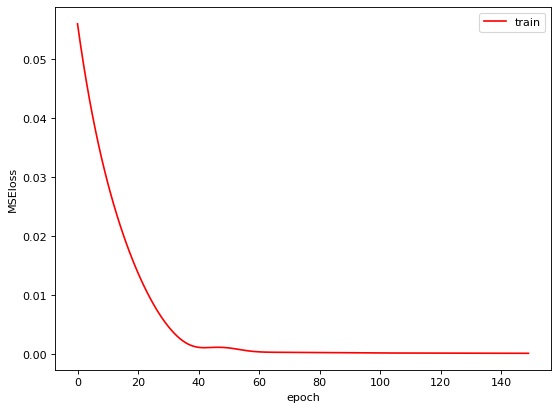

In [17]:
plt.figure(figsize=[8,6], dpi=80)
plt.plot(np.array(loss_all_1), 'r', label = 'train')
plt.xlabel("epoch")
plt.ylabel("MSEloss")
plt.legend()

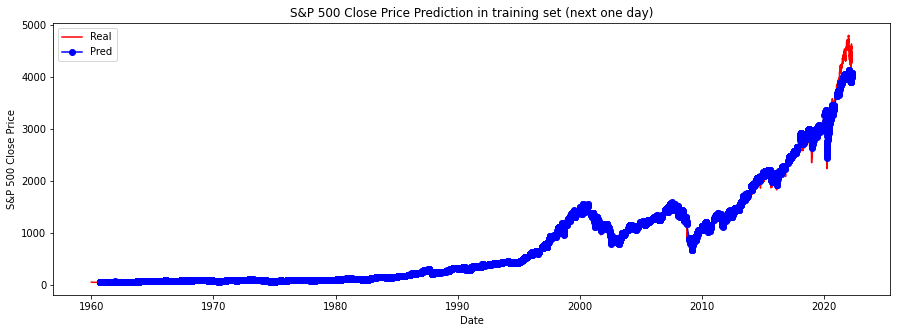

In [18]:
# plot the prediction price and the real price in the training dataset
out_temp = np.concatenate((output.detach().numpy()[:, [0]], 
                           output.detach().numpy()[:, [0]],output.detach().numpy()[:, [0]],
                           output.detach().numpy()[:, [0]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(price.Date, dataset_original[:,3], color = 'red', label = 'Real')
plt.plot(date_train, predicted_price, color = 'blue', label = 'Pred', marker = 'o')  #change
plt.title('S&P 500 Close Price Prediction in training set(next one day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

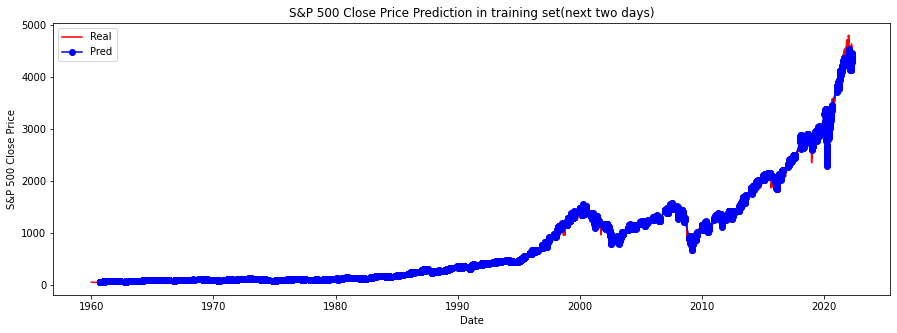

In [83]:
# plot the prediction price and the real price in the training dataset
out_temp = np.concatenate((output.detach().numpy()[:, [1]], 
                           output.detach().numpy()[:, [1]],
                           output.detach().numpy()[:, [1]],
                           output.detach().numpy()[:, [1]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(price.Date, dataset_original[:,3], color = 'red', label = 'Real')
plt.plot(date_train, predicted_price, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in training set(next two days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

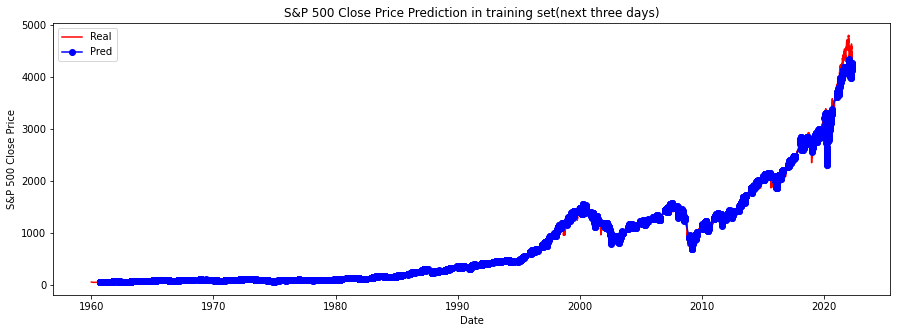

In [84]:
# plot the prediction price and the real price in the training dataset
out_temp = np.concatenate((output.detach().numpy()[:, [2]], 
                           output.detach().numpy()[:, [2]],
                           output.detach().numpy()[:, [2]],
                           output.detach().numpy()[:, [2]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(price.Date, dataset_original[:,3], color = 'red', label = 'Real')
plt.plot(date_train, predicted_price, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in training set(next three days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

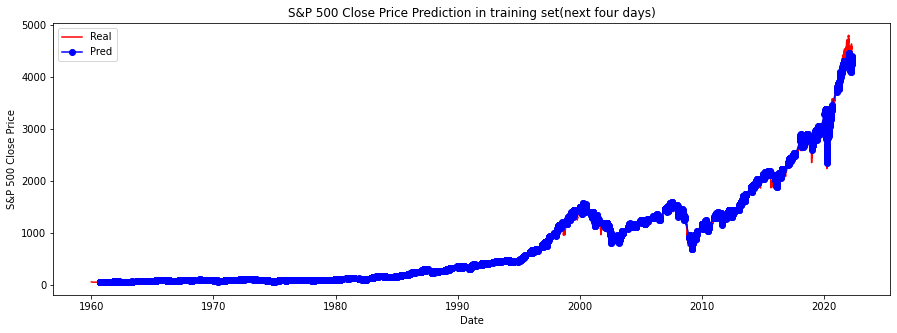

In [85]:
# plot the prediction price and the real price in the training dataset
out_temp = np.concatenate((output.detach().numpy()[:, [3]], 
                           output.detach().numpy()[:, [3]],
                           output.detach().numpy()[:, [3]],
                           output.detach().numpy()[:, [3]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(price.Date, dataset_original[:,3], color = 'red', label = 'Real')
plt.plot(date_train, predicted_price, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in training set(next four days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

From the MSE loss figure, the loss for the training set keep decrease. Through the prediction plot we can see that at the end of the figure, there is a little under-fitting.

## Test RNN accuracy in predicting the next one, two, three, and four datapoints in the dataset from Jan 1, 1980 through the present day.

### Accuracy will be computed in terms of error defined as prediction_error := |predicted_price - actual_price| / actual_price.

In [20]:
# compute prediction_error := (predicted_price - actual_price) / actual_price 
def prediction_error(pred,target):
    error = abs(pred - target)/target
    return error

In [21]:
# store mean error for the training dataset 用训练集 测试 他的欠拟合程度
mean_train = []
std_train = []
skewness_train = []
kurtosis_train = []
# store mean error for the test dataset  #测试集 测试 过拟合程度
mean_test = []
std_test = []
skewness_test = []
kurtosis_test = []

### Training dataset prediction_error as a function of timestamp.

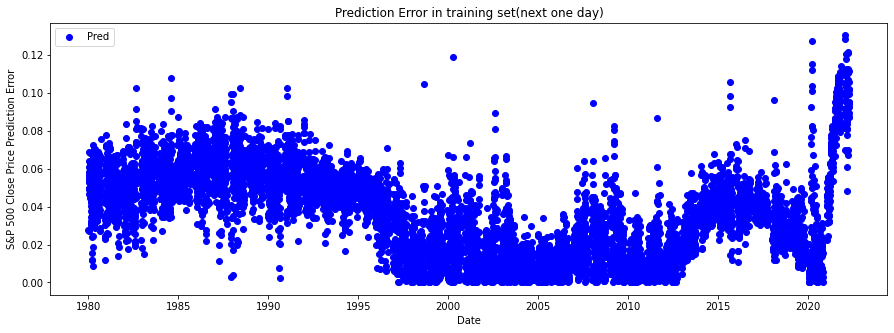

In [22]:
out_temp = np.concatenate((output.detach().numpy()[:, [0]], 
                           output.detach().numpy()[:, [0]],
                           output.detach().numpy()[:, [0]],
                           output.detach().numpy()[:, [0]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (Y_train[:, :, 0], Y_train[:, :, 0],Y_train[:, :, 0],Y_train[:, :, 0]), axis = 1)
target_train = scaler.inverse_transform(out_temp)[:, [0]]
error_train = prediction_error(predicted_price,target_train)
myDatetime = np.datetime64("1980-01-01")
date_train_partial = date_train[date_train>myDatetime]
error_partial = error_train[date_train>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_train_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in training set(next one day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
mean_train.append(np.mean(error_partial))
std_train.append(np.std(error_partial))
skewness_train.append(stats.skew(error_partial))
kurtosis_train.append(stats.kurtosis(error_partial))

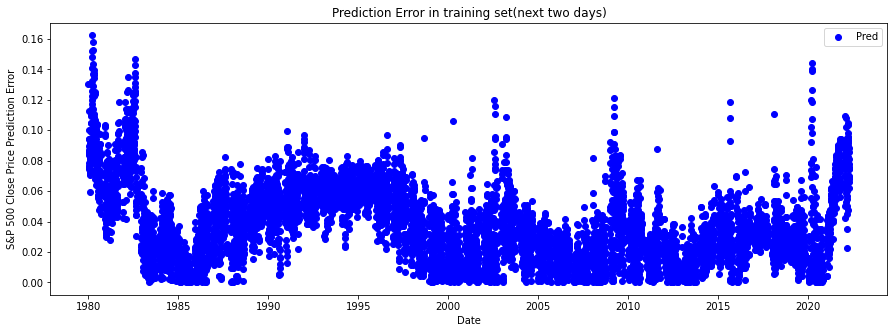

In [23]:
out_temp = np.concatenate((output.detach().numpy()[:, [1]], 
                           output.detach().numpy()[:, [1]],
                           output.detach().numpy()[:, [1]],
                           output.detach().numpy()[:, [1]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (Y_train[:, :, 1], Y_train[:, :, 1],Y_train[:, :, 1],Y_train[:, :, 1]), axis = 1)
target_train = scaler.inverse_transform(out_temp)[:, [0]]
error_train = prediction_error(predicted_price,target_train)
myDatetime = np.datetime64("1980-01-01")
date_train_partial = date_train[date_train>myDatetime]
error_partial = error_train[date_train>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_train_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in training set(next two days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
mean_train.append(np.mean(error_partial))
std_train.append(np.std(error_partial))
skewness_train.append(stats.skew(error_partial))
kurtosis_train.append(stats.kurtosis(error_partial))

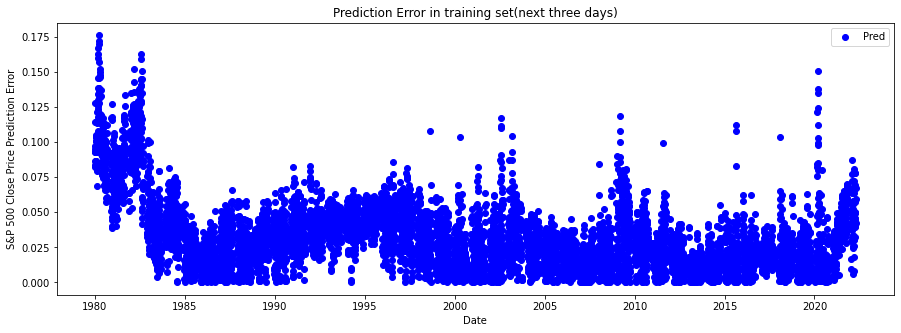

In [24]:
out_temp = np.concatenate((output.detach().numpy()[:, [2]], 
                           output.detach().numpy()[:, [2]],
                           output.detach().numpy()[:, [2]],
                           output.detach().numpy()[:, [2]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (Y_train[:, :, 2], Y_train[:, :, 2],Y_train[:, :, 2],Y_train[:, :, 2]), axis = 1)
target_train = scaler.inverse_transform(out_temp)[:, [0]]
error_train = prediction_error(predicted_price,target_train)
myDatetime = np.datetime64("1980-01-01")
date_train_partial = date_train[date_train>myDatetime]
error_partial = error_train[date_train>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_train_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in training set(next three days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
mean_train.append(np.mean(error_partial))
std_train.append(np.std(error_partial))
skewness_train.append(stats.skew(error_partial))
kurtosis_train.append(stats.kurtosis(error_partial))

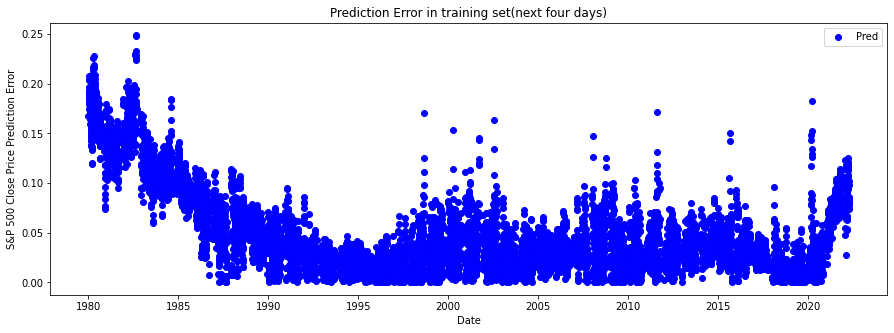

In [25]:
out_temp = np.concatenate((output.detach().numpy()[:, [3]], 
                           output.detach().numpy()[:, [3]],
                           output.detach().numpy()[:, [3]],
                           output.detach().numpy()[:, [3]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (Y_train[:, :, 3], Y_train[:, :, 3],Y_train[:, :, 3],Y_train[:, :, 3]), axis = 1)
target_train = scaler.inverse_transform(out_temp)[:, [0]]
error_train = prediction_error(predicted_price,target_train)
myDatetime = np.datetime64("1980-01-01")
date_train_partial = date_train[date_train>myDatetime]
error_partial = error_train[date_train>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_train_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in training set(next four days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
mean_train.append(np.mean(error_partial))
std_train.append(np.std(error_partial))
skewness_train.append(stats.skew(error_partial))
kurtosis_train.append(stats.kurtosis(error_partial))

### Testing dataset prediction_error as a function of timestamp.

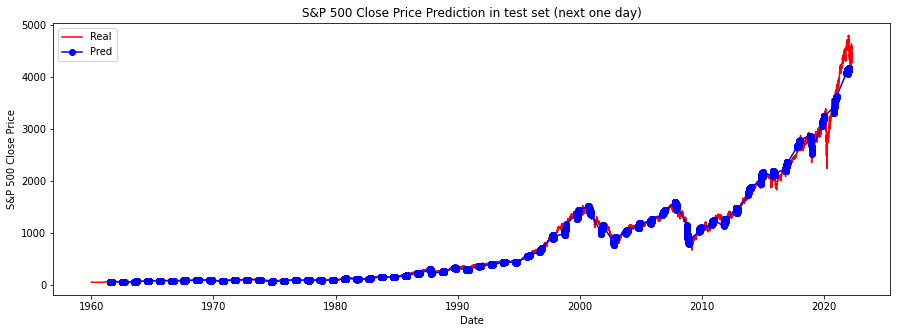

In [27]:
test_inputs = Variable(torch.from_numpy(X_test).float())
output_test, _ = rnn_1(test_inputs)
out_temp = np.concatenate((output_test.detach().numpy()[:, [0]], 
                           output_test.detach().numpy()[:, [0]],
                           output_test.detach().numpy()[:, [0]],
                           output_test.detach().numpy()[:, [0]]), axis=1)
predicted_price_test = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(price.Date, dataset_original[:,3], color = 'red', label = 'Real')
plt.plot(date_test,
         predicted_price_test, color = 'blue', label = 'Pred', marker='o')
plt.title('S&P 500 Close Price Prediction in test set (next one day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

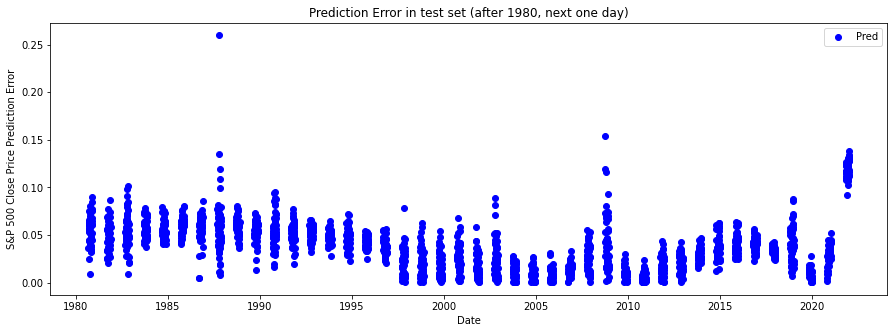

In [28]:
out_temp = np.concatenate( (Y_test[:, :, 0], Y_test[:, :, 0],Y_test[:, :, 0],Y_test[:, :, 0]), axis = 1)
target_test = scaler.inverse_transform(out_temp)[:, [0]]
error_test = prediction_error(predicted_price_test,target_test)
myDatetime = np.datetime64("1980-01-01")
date_test_partial = date_test[date_test>myDatetime]
error_partial = error_test[date_test>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_test_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in test set (after 1980, next one day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
mean_test.append(np.mean(error_partial))
std_test.append(np.std(error_partial))
skewness_test.append(stats.skew(error_partial))
kurtosis_test.append(stats.kurtosis(error_partial))

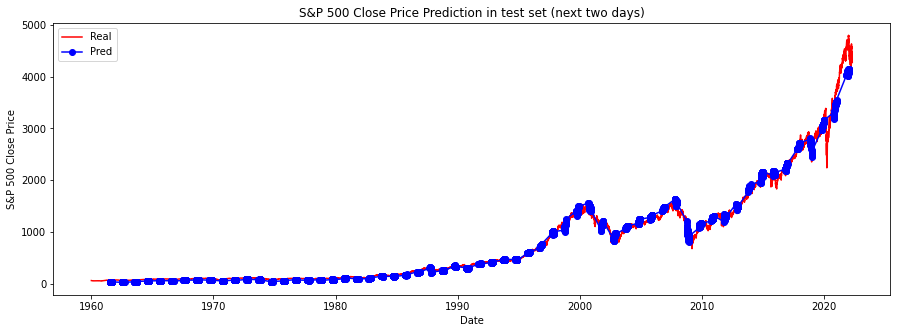

In [41]:
test_inputs = Variable(torch.from_numpy(X_test).float())
output_test, _ = rnn_1(test_inputs)
out_temp = np.concatenate((output_test.detach().numpy()[:, [1]], 
                           output_test.detach().numpy()[:, [1]],
                           output_test.detach().numpy()[:, [1]],
                           output_test.detach().numpy()[:, [1]]), axis=1)
predicted_price_test = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(price.Date, dataset_original[:,3], color = 'red', label = 'Real')
plt.plot(date_test,
         predicted_price_test, color = 'blue', label = 'Pred', marker='o')
plt.title('S&P 500 Close Price Prediction in test set (next two days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

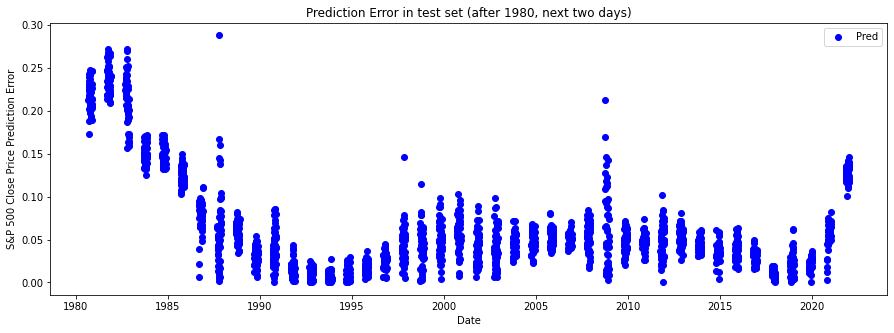

In [42]:
out_temp = np.concatenate( (Y_test[:, :, 1], Y_test[:, :, 1],Y_test[:, :, 1],Y_test[:, :, 1]), axis = 1)
target_test = scaler.inverse_transform(out_temp)[:, [0]]
error_test = prediction_error(predicted_price_test,target_test)
myDatetime = np.datetime64("1980-01-01")
date_test_partial = date_test[date_test>myDatetime]
error_partial = error_test[date_test>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_test_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in test set (after 1980, next two days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
mean_test.append(np.mean(error_partial))
std_test.append(np.std(error_partial))
skewness_test.append(stats.skew(error_partial))
kurtosis_test.append(stats.kurtosis(error_partial))

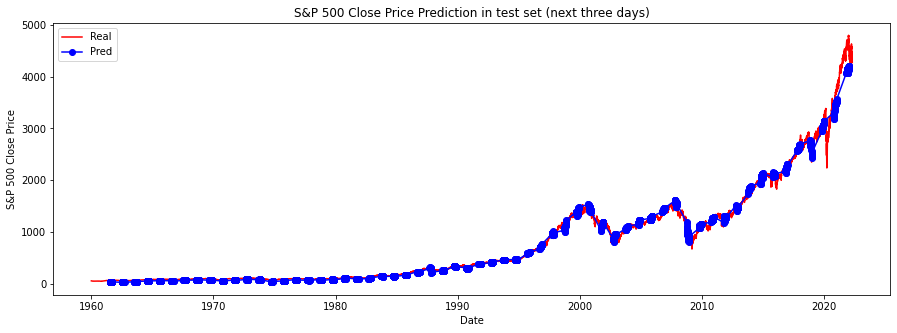

In [43]:
test_inputs = Variable(torch.from_numpy(X_test).float())
output_test, _ = rnn_1(test_inputs)
out_temp = np.concatenate((output_test.detach().numpy()[:, [2]], 
                           output_test.detach().numpy()[:, [2]],
                           output_test.detach().numpy()[:, [2]],
                           output_test.detach().numpy()[:, [2]]), axis=1)
predicted_price_test = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(price.Date, dataset_original[:,3], color = 'red', label = 'Real')
plt.plot(date_test,
         predicted_price_test, color = 'blue', label = 'Pred', marker='o')
plt.title('S&P 500 Close Price Prediction in test set (next three days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

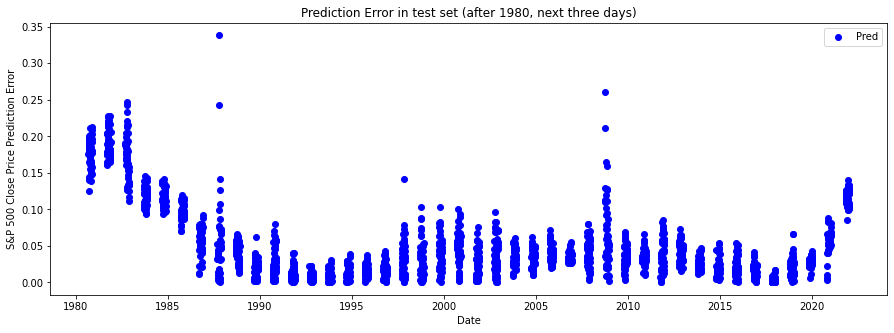

In [44]:
out_temp = np.concatenate( (Y_test[:, :, 2], Y_test[:, :, 2],Y_test[:, :, 2],Y_test[:, :, 2]), axis = 1)
target_test = scaler.inverse_transform(out_temp)[:, [0]]
error_test = prediction_error(predicted_price_test,target_test)
myDatetime = np.datetime64("1980-01-01")
date_test_partial = date_test[date_test>myDatetime]
error_partial = error_test[date_test>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_test_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in test set (after 1980, next three days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
mean_test.append(np.mean(error_partial))
std_test.append(np.std(error_partial))
skewness_test.append(stats.skew(error_partial))
kurtosis_test.append(stats.kurtosis(error_partial))

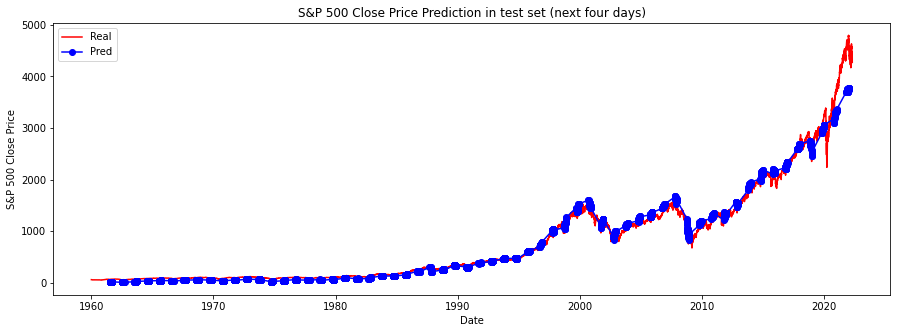

In [45]:
test_inputs = Variable(torch.from_numpy(X_test).float())
output_test, _ = rnn_1(test_inputs)
out_temp = np.concatenate((output_test.detach().numpy()[:, [3]], 
                           output_test.detach().numpy()[:, [3]],
                           output_test.detach().numpy()[:, [3]],
                           output_test.detach().numpy()[:, [3]]), axis=1)
predicted_price_test = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(price.Date, dataset_original[:,3], color = 'red', label = 'Real')
plt.plot(date_test,
         predicted_price_test, color = 'blue', label = 'Pred', marker='o')
plt.title('S&P 500 Close Price Prediction in test set (next four days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

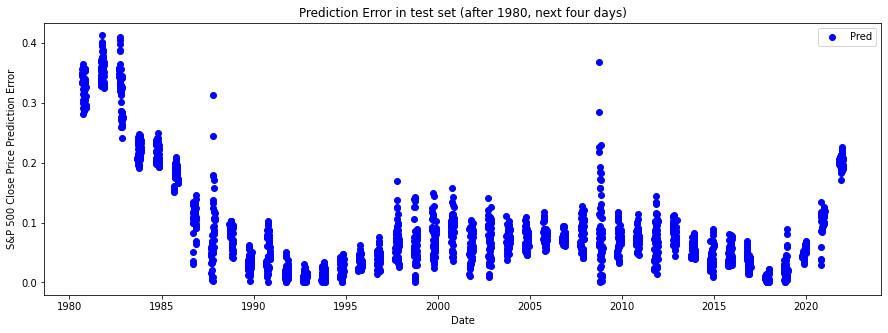

In [46]:
out_temp = np.concatenate( (Y_test[:, :, 3], Y_test[:, :, 3],Y_test[:, :, 3],Y_test[:, :, 3]), axis = 1)
target_test = scaler.inverse_transform(out_temp)[:, [0]]
error_test = prediction_error(predicted_price_test,target_test)
myDatetime = np.datetime64("1980-01-01")
date_test_partial = date_test[date_test>myDatetime]
error_partial = error_test[date_test>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_test_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in test set (after 1980, next four days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
mean_test.append(np.mean(error_partial))
std_test.append(np.std(error_partial))
skewness_test.append(stats.skew(error_partial))
kurtosis_test.append(stats.kurtosis(error_partial))

## Optimize RNN performance to yield maximum achievable accuracy

In [47]:
# construct data structure with validation set 用x—val来纠正 如果差距大 就会通过val来更新
X_train = []; Y_train = []; date_train = []
X_val = []; Y_val = []; date_val = []
X_test = []; Y_test = []; date_test = []
for i in range(X_full.shape[0]):
    if(i  %  253 >= 200):
        X_test.append(X_full[i])
        Y_test.append(Y_full[i])
        date_test.append(date_full[i])
    elif (i % 253 < 160):
        X_train.append(X_full[i])
        Y_train.append(Y_full[i])
        date_train.append(date_full[i])
    else:
        X_val.append(X_full[i])
        Y_val.append(Y_full[i])
        date_val.append(date_full[i])
X_train, Y_train, date_train = np.array(X_train), np.array(Y_train), np.array(date_train) 
X_val, Y_val, date_val = np.array(X_val), np.array(Y_val), np.array(date_val) 
X_test, Y_test, date_test = np.array(X_test), np.array(Y_test), np.array(date_test)

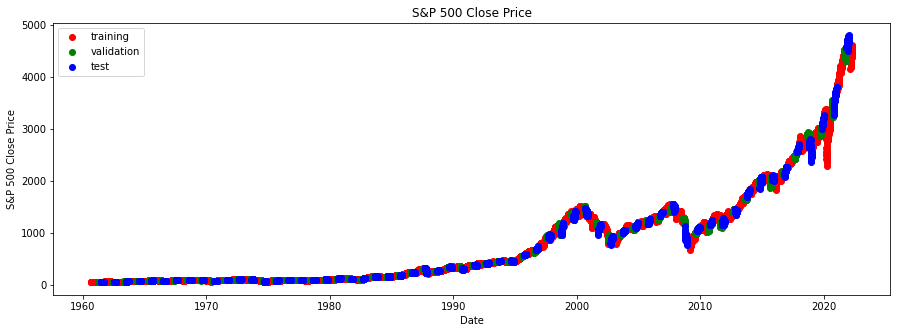

In [48]:
# Visualizing training dataset and test dataset and validation dataset
out_temp = np.concatenate((Y_train[:, 0, [0]],
                            Y_train[:, 0, [0]],
                            Y_train[:, 0, [0]],
                           Y_train[:, 0, [0]]), axis=1)
price_train = scaler.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate((Y_val[:, 0, [0]], 
                            Y_val[:, 0, [0]],
                            Y_val[:, 0, [0]],
                           Y_val[:, 0, [0]]), axis=1)
price_val = scaler.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate((Y_test[:, 0, [0]], 
                            Y_test[:, 0, [0]],
                            Y_test[:, 0, [0]],
                           Y_test[:, 0, [0]]), axis=1)
price_test = scaler.inverse_transform(out_temp)[:, [0]]
# Visualising training dataset and test dataset
plt.figure(figsize=(15, 5));
plt.plot(date_train, price_train[:,0], color = 'red', label = 'training', marker= 'o', linestyle='None')
plt.plot(date_val, price_val[:,0], color = 'green', label = 'validation', marker= 'o', linestyle='None')
plt.plot(date_test, price_test[:,0], color = 'blue', label = 'test', marker= 'o', linestyle='None')
plt.title('S&P 500 Close Price')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

In [49]:
# parameters for the RNN model
hidden_size = 32
n_layers = 2
learning_rate = 0.005
rnn_2 = RNN(input_size, output_size, hidden_size, n_layers)
optimizer = torch.optim.Adam(rnn_2.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [50]:
# The RNN model structure
rnn_2

RNN(
  (rnn): RNN(4, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=4, bias=True)
)

In [51]:
# Display parameters in the model
for name, param in rnn_2.named_parameters():
    print(name, param.data.shape)

rnn.weight_ih_l0 torch.Size([32, 4])
rnn.weight_hh_l0 torch.Size([32, 32])
rnn.bias_ih_l0 torch.Size([32])
rnn.bias_hh_l0 torch.Size([32])
rnn.weight_ih_l1 torch.Size([32, 32])
rnn.weight_hh_l1 torch.Size([32, 32])
rnn.bias_ih_l1 torch.Size([32])
rnn.bias_hh_l1 torch.Size([32])
fc.weight torch.Size([4, 32])
fc.bias torch.Size([4])


In [52]:
# begin training
loss_all_2 = []
loss_all_2_val = []
for epoch in range(70):
    # change training sets into torch tensors
    inputs = Variable(torch.from_numpy(X_train).float())
    labels = Variable(torch.from_numpy(Y_train).float())

    # set zero gradients
    optimizer.zero_grad()

    # set forward pass
    output, hidden = rnn_2(inputs)

    # calculate loss
    loss = criterion(output.reshape(-1), labels.view(-1))
    loss_all_2 += [loss.item()]

    # backward pass
    loss.backward(retain_graph=True)

    # loss for validation set
    inputs_val = torch.from_numpy(X_val).float()
    labels_val = torch.from_numpy(Y_val).float()
    output_val, hidden_val = rnn_2(inputs_val)
    loss_val = criterion(output_val.reshape(-1), labels_val.view(-1))
    loss_all_2_val += [loss_val.item()]

    # show loss
    if epoch % 10 == 0:
        print('Epoch: %d, Loss: %.5f, Loss_val: %.5f' % (epoch, loss.item(), loss_val.item()))

    # update weights
    optimizer.step()

Epoch: 0, Loss: 0.07988, Loss_val: 0.07992
Epoch: 10, Loss: 0.00315, Loss_val: 0.00319
Epoch: 20, Loss: 0.00170, Loss_val: 0.00170
Epoch: 30, Loss: 0.00063, Loss_val: 0.00065
Epoch: 40, Loss: 0.00025, Loss_val: 0.00026
Epoch: 50, Loss: 0.00018, Loss_val: 0.00018
Epoch: 60, Loss: 0.00008, Loss_val: 0.00009


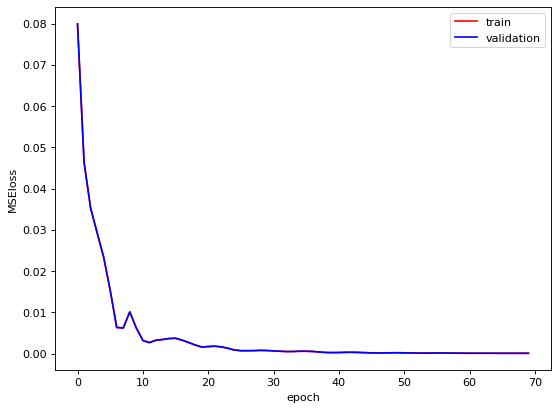

In [87]:
plt.figure(figsize=[8,6], dpi=80)
plt.plot(np.array(loss_all_2), 'r', label = 'train')
plt.plot(np.array(loss_all_2_val), 'b', label = 'validation')
plt.xlabel("epoch")
plt.ylabel("MSEloss")
plt.legend()

### Training dataset prediction_error as a function of timestamp(Optimize).

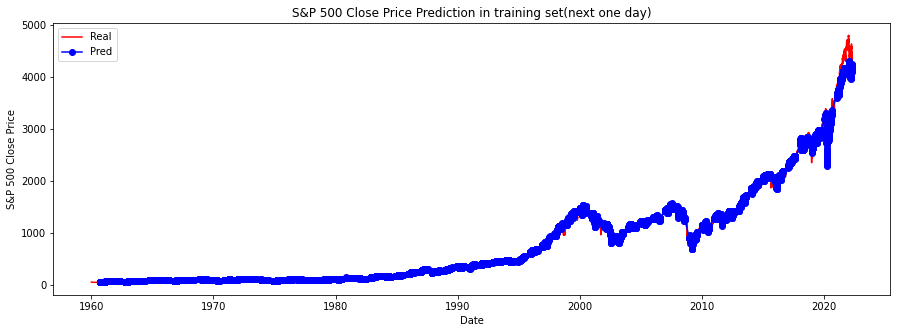

In [54]:
# plot the prediction price and the real price in the training dataset
out_temp = np.concatenate((output.detach().numpy()[:, [0]],
                            output.detach().numpy()[:, [0]],
                            output.detach().numpy()[:, [0]],
                           output.detach().numpy()[:, [0]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(price.Date, dataset_original[:,3], color = 'red', label = 'Real')
plt.plot(date_train, predicted_price, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in training set(next one day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

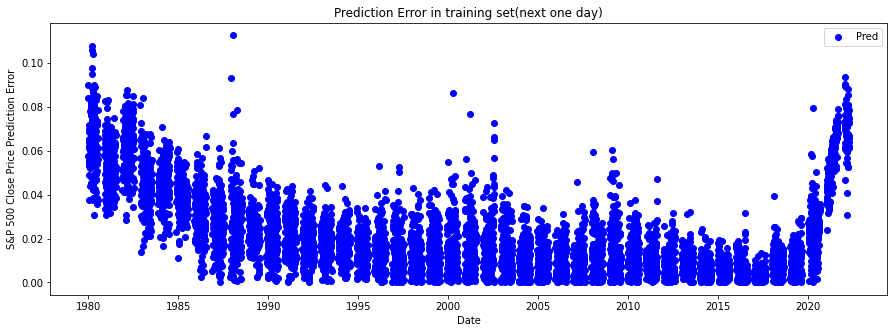

In [88]:
out_temp = np.concatenate((output.detach().numpy()[:, [0]], 
                            output.detach().numpy()[:, [0]],
                            output.detach().numpy()[:, [0]],
                           output.detach().numpy()[:, [0]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (Y_train[:, :, 0], Y_train[:, :, 0],Y_train[:, :, 0],Y_train[:, :, 0]), axis = 1)
target_train = scaler.inverse_transform(out_temp)[:, [0]]
error_train = prediction_error(predicted_price,target_train)
myDatetime = np.datetime64("1980-01-01")
date_train_partial = date_train[date_train>myDatetime]
error_partial = error_train[date_train>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_train_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in training set(next one day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
mean_train.append(np.mean(error_partial))
std_train.append(np.std(error_partial))
skewness_train.append(stats.skew(error_partial))
kurtosis_train.append(stats.kurtosis(error_partial))

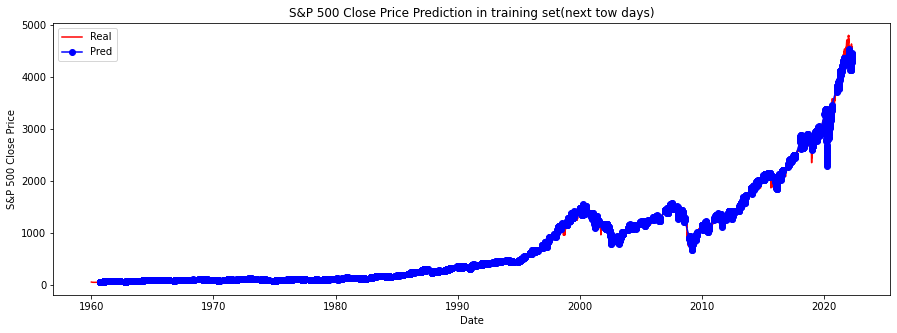

In [56]:
# plot the prediction price and the real price in the training dataset
out_temp = np.concatenate((output.detach().numpy()[:, [1]], 
                            output.detach().numpy()[:, [1]],
                            output.detach().numpy()[:, [1]],
                           output.detach().numpy()[:, [1]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(price.Date, dataset_original[:,3], color = 'red', label = 'Real')
plt.plot(date_train, predicted_price, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in training set(next tow days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

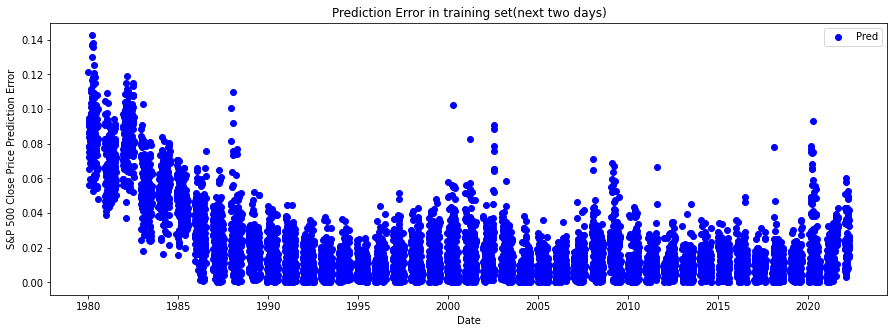

In [86]:
out_temp = np.concatenate((output.detach().numpy()[:, [1]], 
                            output.detach().numpy()[:, [1]],
                            output.detach().numpy()[:, [1]],
                           output.detach().numpy()[:, [1]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (Y_train[:, :, 1], Y_train[:, :, 1],Y_train[:, :, 1],Y_train[:, :, 1]), axis = 1)
target_train = scaler.inverse_transform(out_temp)[:, [0]]
error_train = prediction_error(predicted_price,target_train)
myDatetime = np.datetime64("1980-01-01")
date_train_partial = date_train[date_train>myDatetime]
error_partial = error_train[date_train>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_train_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in training set(next two days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
mean_train.append(np.mean(error_partial))
std_train.append(np.std(error_partial))
skewness_train.append(stats.skew(error_partial))
kurtosis_train.append(stats.kurtosis(error_partial))

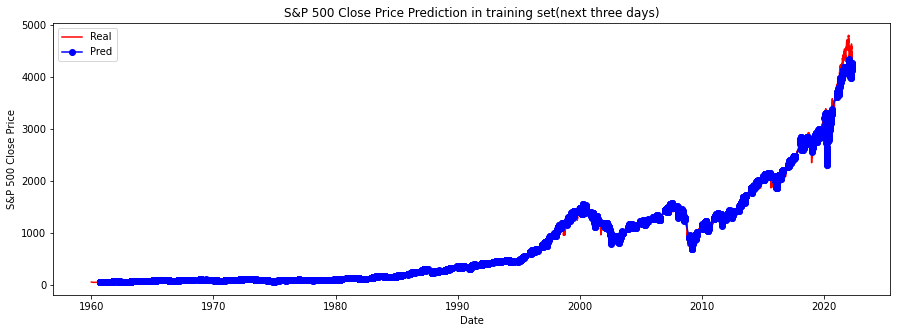

In [89]:
# plot the prediction price and the real price in the training dataset
out_temp = np.concatenate((output.detach().numpy()[:, [2]], 
                            output.detach().numpy()[:, [2]],
                            output.detach().numpy()[:, [2]],
                           output.detach().numpy()[:, [2]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(price.Date, dataset_original[:,3], color = 'red', label = 'Real')
plt.plot(date_train, predicted_price, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in training set(next three days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

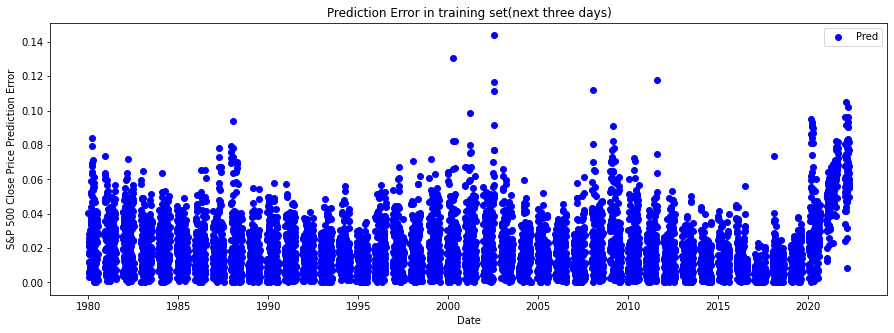

In [90]:
out_temp = np.concatenate((output.detach().numpy()[:, [2]], 
                            output.detach().numpy()[:, [2]],
                            output.detach().numpy()[:, [2]],
                           output.detach().numpy()[:, [2]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (Y_train[:, :, 2], Y_train[:, :, 2],Y_train[:, :, 2],Y_train[:, :, 2]), axis = 1)
target_train = scaler.inverse_transform(out_temp)[:, [0]]
error_train = prediction_error(predicted_price,target_train)
myDatetime = np.datetime64("1980-01-01")
date_train_partial = date_train[date_train>myDatetime]
error_partial = error_train[date_train>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_train_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in training set(next three days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
mean_train.append(np.mean(error_partial))
std_train.append(np.std(error_partial))
skewness_train.append(stats.skew(error_partial))
kurtosis_train.append(stats.kurtosis(error_partial))

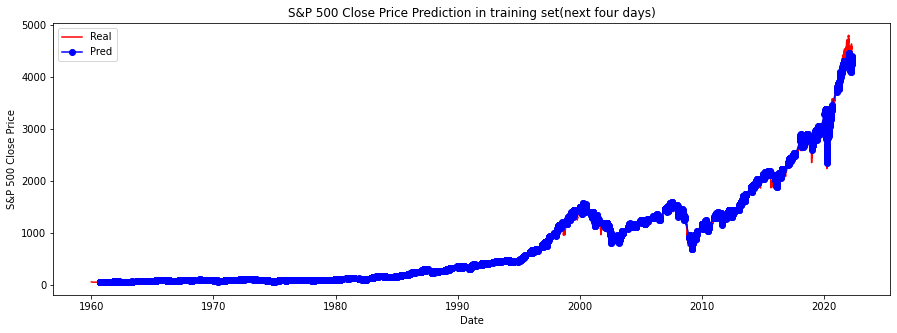

In [60]:
# plot the prediction price and the real price in the training dataset
out_temp = np.concatenate((output.detach().numpy()[:, [3]], 
                            output.detach().numpy()[:, [3]],
                            output.detach().numpy()[:, [3]],
                           output.detach().numpy()[:, [3]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(price.Date, dataset_original[:,3], color = 'red', label = 'Real')
plt.plot(date_train, predicted_price, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in training set(next four days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

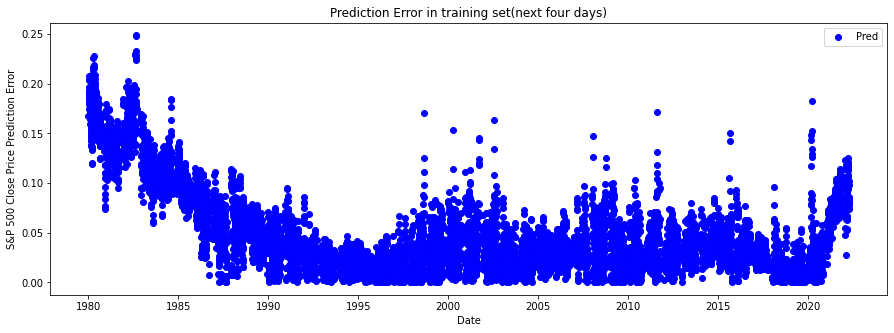

In [29]:
out_temp = np.concatenate((output.detach().numpy()[:, [3]], 
                            output.detach().numpy()[:, [3]],
                            output.detach().numpy()[:, [3]],
                           output.detach().numpy()[:, [3]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (Y_train[:, :, 3], Y_train[:, :, 3],Y_train[:, :, 3],Y_train[:, :, 3]), axis = 1)
target_train = scaler.inverse_transform(out_temp)[:, [0]]
error_train = prediction_error(predicted_price,target_train)
myDatetime = np.datetime64("1980-01-01")
date_train_partial = date_train[date_train>myDatetime]
error_partial = error_train[date_train>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_train_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in training set(next four days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
mean_train.append(np.mean(error_partial))
std_train.append(np.std(error_partial))
skewness_train.append(stats.skew(error_partial))
kurtosis_train.append(stats.kurtosis(error_partial))

### Testing dataset prediction_error as a function of timestamp after Optimize.

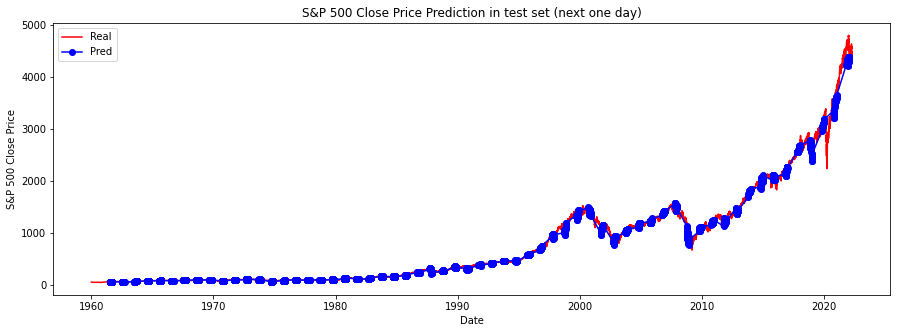

In [91]:
test_inputs = Variable(torch.from_numpy(X_test).float())
output_test, _ = rnn_2(test_inputs)
out_temp = np.concatenate((output_test.detach().numpy()[:, [0]], 
                            output_test.detach().numpy()[:, [0]],
                            output_test.detach().numpy()[:, [0]],
                           output_test.detach().numpy()[:, [0]]), axis=1)
predicted_price_test = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(price.Date, dataset_original[:,3], color = 'red', label = 'Real')
plt.plot(date_test,
         predicted_price_test, color = 'blue', label = 'Pred', marker='o')
plt.title('S&P 500 Close Price Prediction in test set (next one day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

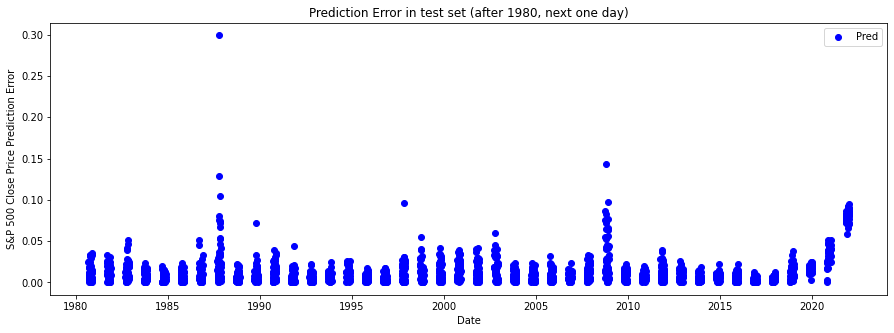

In [63]:
out_temp = np.concatenate( (Y_test[:, :, 0], Y_test[:, :, 0],Y_test[:, :, 0],Y_test[:, :, 0]), axis = 1)
target_test = scaler.inverse_transform(out_temp)[:, [0]]
error_test = prediction_error(predicted_price_test,target_test)
myDatetime = np.datetime64("1980-01-01")
date_test_partial = date_test[date_test>myDatetime]
error_partial = error_test[date_test>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_test_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in test set (after 1980, next one day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
mean_test.append(np.mean(error_partial))
std_test.append(np.std(error_partial))
skewness_test.append(stats.skew(error_partial))
kurtosis_test.append(stats.kurtosis(error_partial))

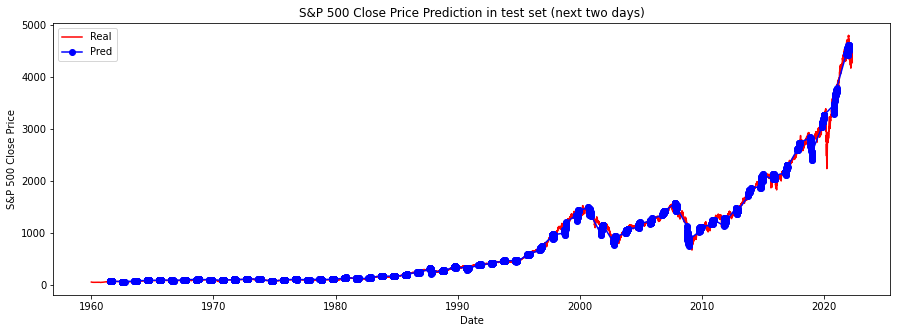

In [64]:
test_inputs = Variable(torch.from_numpy(X_test).float())
output_test, _ = rnn_2(test_inputs)
out_temp = np.concatenate((output_test.detach().numpy()[:, [1]], 
                            output_test.detach().numpy()[:, [1]],
                            output_test.detach().numpy()[:, [1]],
                           output_test.detach().numpy()[:, [1]]), axis=1)
predicted_price_test = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(price.Date, dataset_original[:,3], color = 'red', label = 'Real')
plt.plot(date_test,
         predicted_price_test, color = 'blue', label = 'Pred', marker='o')
plt.title('S&P 500 Close Price Prediction in test set (next two days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

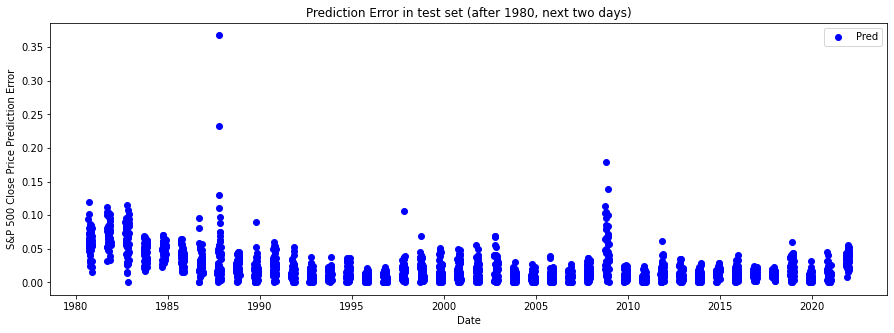

In [65]:
out_temp = np.concatenate( (Y_test[:, :, 1], Y_test[:, :, 1],Y_test[:, :, 1],Y_test[:, :, 1]), axis = 1)
target_test = scaler.inverse_transform(out_temp)[:, [0]]
error_test = prediction_error(predicted_price_test,target_test)
myDatetime = np.datetime64("1980-01-01")
date_test_partial = date_test[date_test>myDatetime]
error_partial = error_test[date_test>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_test_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in test set (after 1980, next two days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
mean_test.append(np.mean(error_partial))
std_test.append(np.std(error_partial))
skewness_test.append(stats.skew(error_partial))
kurtosis_test.append(stats.kurtosis(error_partial))

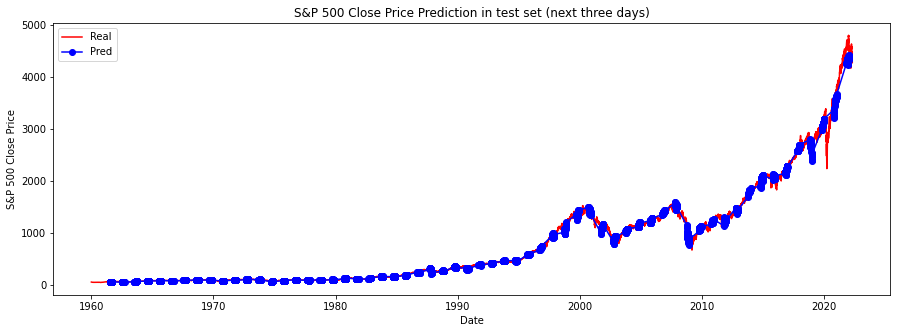

In [66]:
test_inputs = Variable(torch.from_numpy(X_test).float())
output_test, _ = rnn_2(test_inputs)
out_temp = np.concatenate((output_test.detach().numpy()[:, [2]], 
                            output_test.detach().numpy()[:, [2]],
                            output_test.detach().numpy()[:, [2]],
                           output_test.detach().numpy()[:, [2]]), axis=1)
predicted_price_test = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(price.Date, dataset_original[:,3], color = 'red', label = 'Real')
plt.plot(date_test,
         predicted_price_test, color = 'blue', label = 'Pred', marker='o')
plt.title('S&P 500 Close Price Prediction in test set (next three days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

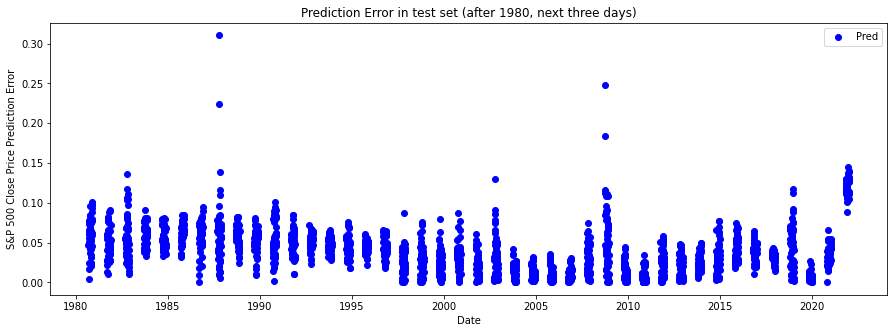

In [33]:
out_temp = np.concatenate( (Y_test[:, :, 2], Y_test[:, :, 2],Y_test[:, :, 2],Y_test[:, :, 2]), axis = 1)
target_test = scaler.inverse_transform(out_temp)[:, [0]]
error_test = prediction_error(predicted_price_test,target_test)
myDatetime = np.datetime64("1980-01-01")
date_test_partial = date_test[date_test>myDatetime]
error_partial = error_test[date_test>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_test_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in test set (after 1980, next three days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
mean_test.append(np.mean(error_partial))
std_test.append(np.std(error_partial))
skewness_test.append(stats.skew(error_partial))
kurtosis_test.append(stats.kurtosis(error_partial))

In [34]:
test_inputs = Variable(torch.from_numpy(X_test).float())
output_test, _ = rnn_2(test_inputs)
out_temp = np.concatenate((output_test.detach().numpy()[:, [3]],
                            output_test.detach().numpy()[:, [3]],
                            output_test.detach().numpy()[:, [3]],
                           output_test.detach().numpy()[:, [3]]), axis=1)
predicted_price_test = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(price.Date, dataset_original[:,3], color = 'red', label = 'Real')
plt.plot(date_test,
         predicted_price_test, color = 'blue', label = 'Pred', marker='o')
plt.title('S&P 500 Close Price Prediction in test set (next four days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

NameError: name 'rnn_2' is not defined

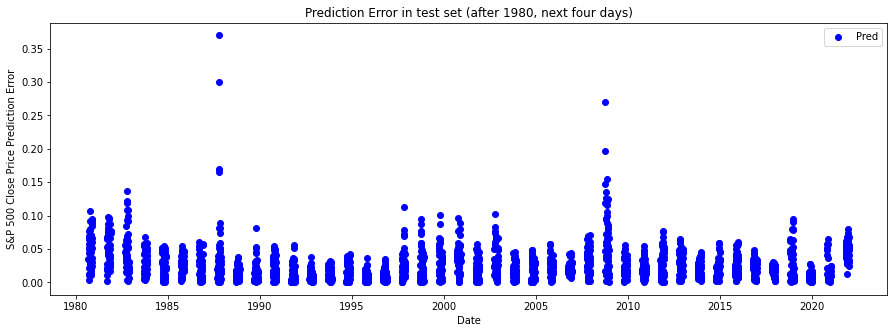

In [69]:
out_temp = np.concatenate( (Y_test[:, :, 3], Y_test[:, :, 3],Y_test[:, :, 3],Y_test[:, :, 3]), axis = 1)
target_test = scaler.inverse_transform(out_temp)[:, [0]]
error_test = prediction_error(predicted_price_test,target_test)
myDatetime = np.datetime64("1980-01-01")
date_test_partial = date_test[date_test>myDatetime]
error_partial = error_test[date_test>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_test_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in test set (after 1980, next four days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
mean_test.append(np.mean(error_partial))
std_test.append(np.std(error_partial))
skewness_test.append(stats.skew(error_partial))
kurtosis_test.append(stats.kurtosis(error_partial))

## Investigate the effect of Input Noise and Uncertainty

In [30]:
# standard deviation 加噪点 9种 强度分别是。。。高斯分布的zaodian
std = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
def NoiseData(dataset, sigma):
    dataset_noise = np.ndarray(shape=dataset.shape, dtype=np.float64)
    #set seed for random numbers
    random.seed(1)
    for i in range(len(dataset)):
        s = np.random.normal(0, sigma, 18)
        index = random.sample(list(range(window_size)), 18)
        dataset_noise[i] = dataset[i]    
        dataset_noise[i, index, 0] = dataset_noise[i, index, 0] + s
    return dataset_noise

In [31]:
#predict next day (idx = 0)
idx = 0
out_temp = np.concatenate( (Y_test[:, :, idx], Y_test[:, :, idx],Y_test[:, :, idx],Y_test[:, :, idx]), axis = 1)
target_test = scaler.inverse_transform(out_temp)[:, [0]]
error_res_all = []
for sigma in std:
    dataset_test_noise = NoiseData(X_test, sigma)
    test_inputs = Variable(torch.from_numpy(dataset_test_noise).float())
    output_test, _ = rnn_2(test_inputs)
    out_temp = np.concatenate((output_test.detach().numpy()[:, [idx]],
                               output_test.detach().numpy()[:, [idx]],
                               output_test.detach().numpy()[:, [idx]],
                               output_test.detach().numpy()[:, [idx]]), axis=1)
    predicted_price_test = scaler.inverse_transform(out_temp)[:, [0]]
    error = prediction_error(predicted_price_test,target_test)
    error_res_all.append(error.reshape(-1))

NameError: name 'rnn_2' is not defined

In [73]:
labels = date_test[:,0]
error_df=pd.DataFrame(error_res_all, columns=labels, index=std).T
error_df

0.001     0.002     0.003     0.005     0.010     0.020  \
1961-07-07  0.001688  0.001494  0.001965  0.001081  0.002205  0.000221   
1961-07-10  0.007613  0.029641  0.004578  0.009644  0.019500  0.224971   
1961-07-11  0.000963  0.002705  0.000563  0.006078  0.004474  0.000934   
1961-07-12  0.003124  0.003272  0.000158  0.003599  0.004087  0.008593   
1961-07-13  0.010527  0.017039  0.031663  0.041311  0.121119  0.052624   
...              ...       ...       ...       ...       ...       ...   
2022-01-05  0.085600  0.085602  0.085604  0.085602  0.085615  0.085631   
2022-01-06  0.070508  0.070508  0.070508  0.070508  0.070508  0.070507   
2022-01-07  0.077027  0.077027  0.077027  0.077027  0.077027  0.077027   
2022-01-10  0.072492  0.072494  0.072504  0.072490  0.072485  0.072498   
2022-01-11  0.080562  0.080562  0.080562  0.080562  0.080562  0.080562   

               0.030     0.050     0.100  
1961-07-07  0.000941  0.000802  0.008257  
1961-07-10  0.098800  0.067878  1.548467  
1961-07-11  0.008719  0.000869  0.122185  
1961-07-12  0.002546  0.001664  0.009909  
1961-07-13  0.169347  1.128131  1.265510  
...              ...       ...       ...  
2022-01-05  0.085607  0.085690  0.085440  
2022-01-06  0.070508  0.070509  0.070506  
2022-01-07  0.077027  0.077027  0.077027  
2022-01-10  0.072521  0.072366  0.072556  
2022-01-11  0.080562  0.080562  0.080564  

[3233 rows x 9 columns]

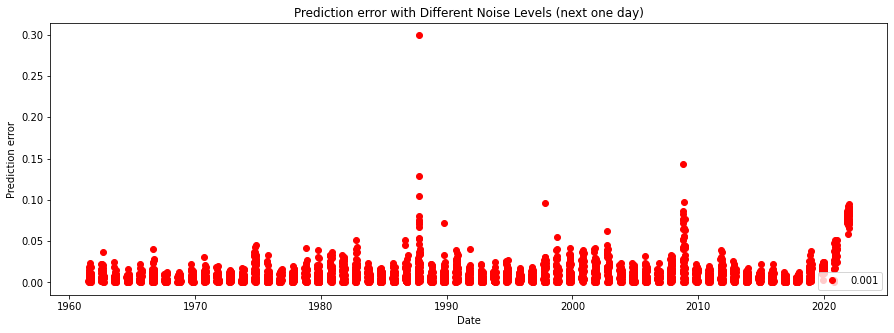

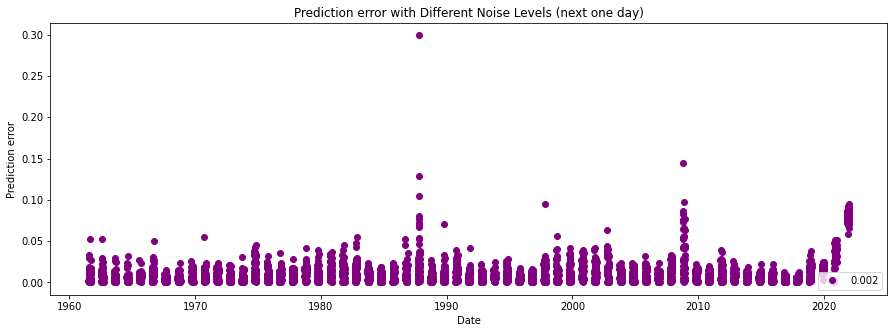

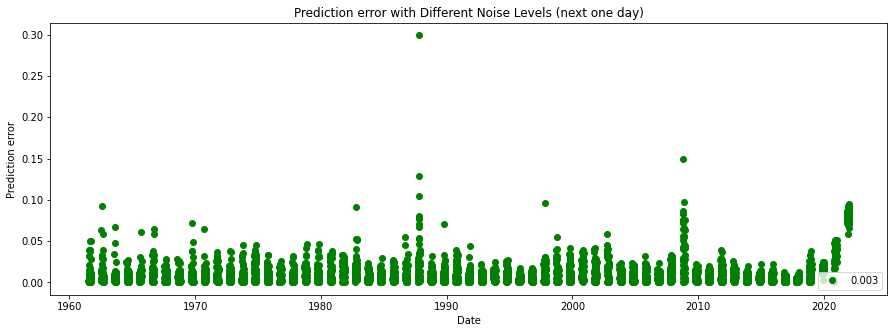

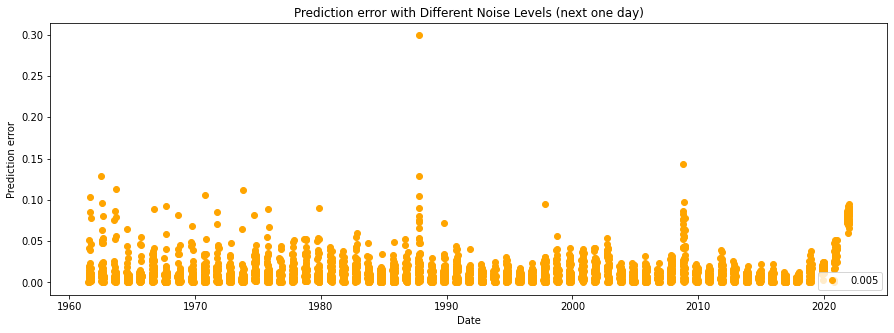

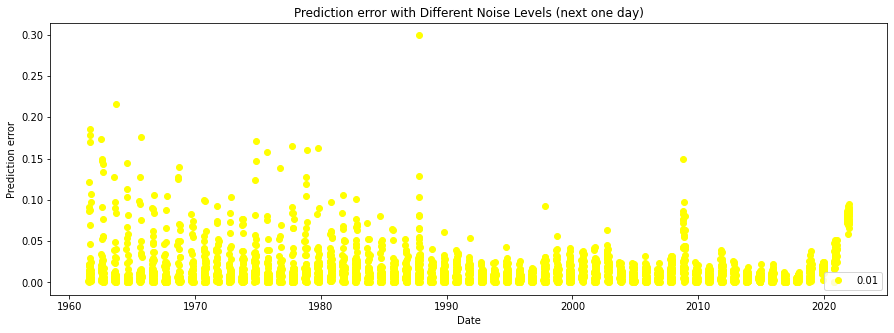

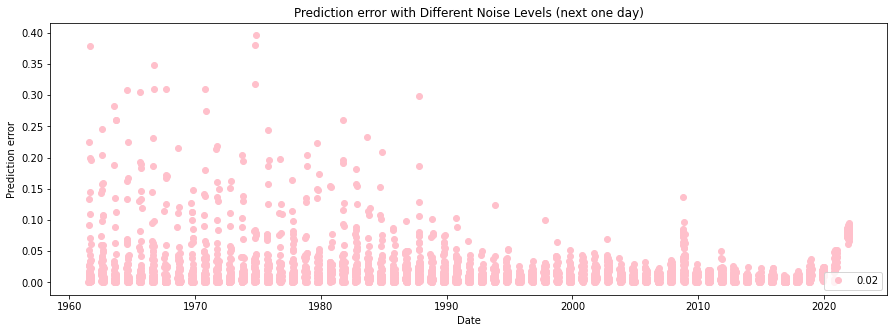

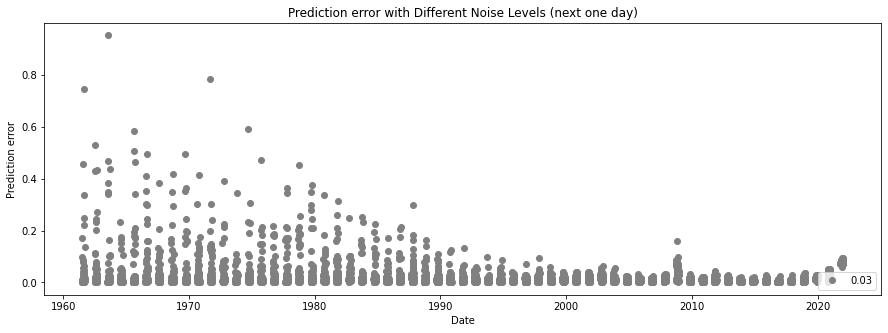

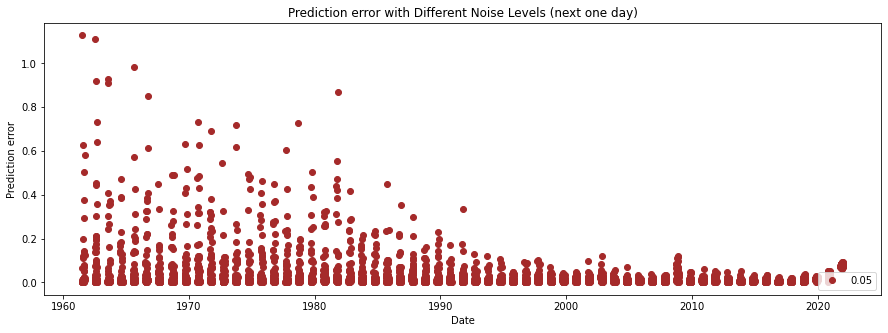

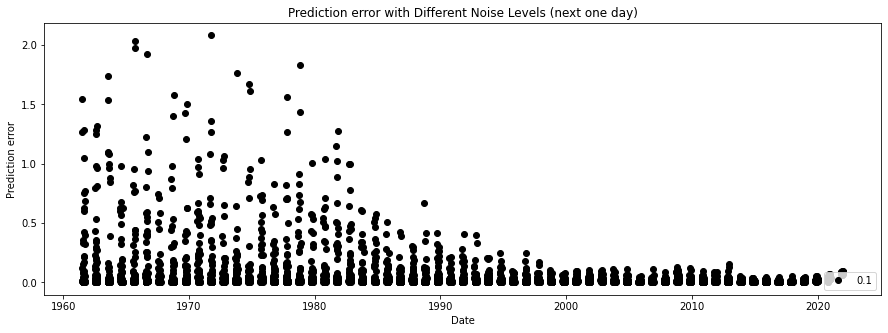

In [74]:
colors= ['red','purple', 'green', 'orange',  'yellow', 'pink', 'grey', 'brown', 'black','blue' ]
for i in range(len(std)): 
    plt.figure(1, figsize=(15, 5))
    plt.plot(date_test, error_res_all[i], color=colors[i], lw=1, label = std[i], marker= 'o', linestyle='None')  
    plt.xlabel('Date')
    plt.ylabel('Prediction error')
    plt.title('Prediction error with Different Noise Levels (next one day)')
    plt.legend(loc="lower right")  
    plt.show()

In [75]:
#predict next two days (idx = 1)
idx = 1
out_temp = np.concatenate( (Y_test[:, :, idx], Y_test[:, :, idx],Y_test[:, :, idx],Y_test[:, :, idx]), axis = 1)
target_test = scaler.inverse_transform(out_temp)[:, [0]]
error_res_all = []
for sigma in std:
    dataset_test_noise = NoiseData(X_test, sigma)
    test_inputs = Variable(torch.from_numpy(dataset_test_noise).float())
    output_test, _ = rnn_2(test_inputs)
    out_temp = np.concatenate((output_test.detach().numpy()[:, [idx]],
                               output_test.detach().numpy()[:, [idx]],
                               output_test.detach().numpy()[:, [idx]],
                               output_test.detach().numpy()[:, [idx]]), axis=1)
    predicted_price_test = scaler.inverse_transform(out_temp)[:, [0]]
    error = prediction_error(predicted_price_test,target_test)
    error_res_all.append(error.reshape(-1))

In [76]:
temp = date_test + pd.Timedelta('1 day')
labels = temp[:,0]
error_df=pd.DataFrame(error_res_all, columns=labels, index=std).T
error_df

0.001     0.002     0.003     0.005     0.010     0.020  \
1961-07-08  0.162846  0.162844  0.162627  0.163075  0.163005  0.163704   
1961-07-11  0.150648  0.101398  0.155386  0.069015  0.227103  0.026010   
1961-07-12  0.166481  0.167326  0.166848  0.164858  0.160314  0.166370   
1961-07-13  0.171121  0.169052  0.172239  0.171129  0.162771  0.193256   
1961-07-14  0.144160  0.142054  0.222423  0.187333  0.230608  0.331766   
...              ...       ...       ...       ...       ...       ...   
2022-01-06  0.018163  0.018161  0.018158  0.018162  0.018181  0.018126   
2022-01-07  0.023141  0.023142  0.023141  0.023142  0.023142  0.023142   
2022-01-08  0.022027  0.022027  0.022027  0.022027  0.022027  0.022027   
2022-01-11  0.030435  0.030431  0.030445  0.030439  0.030483  0.030415   
2022-01-12  0.047882  0.047882  0.047882  0.047882  0.047881  0.047883   

               0.030     0.050     0.100  
1961-07-08  0.161607  0.158168  0.169828  
1961-07-11  0.177107  0.938047  1.012391  
1961-07-12  0.148270  0.174507  0.189942  
1961-07-13  0.167106  0.143551  0.119577  
1961-07-14  0.314202  1.152436  2.390570  
...              ...       ...       ...  
2022-01-06  0.018140  0.018278  0.018065  
2022-01-07  0.023141  0.023140  0.023145  
2022-01-08  0.022027  0.022027  0.022027  
2022-01-11  0.030334  0.030373  0.030365  
2022-01-12  0.047885  0.047879  0.047873  

[3233 rows x 9 columns]

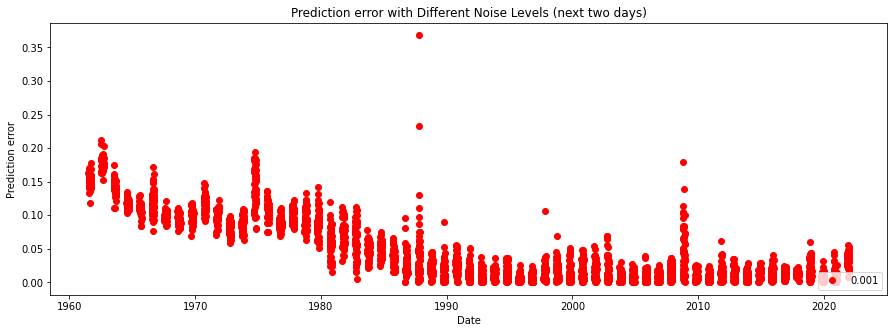

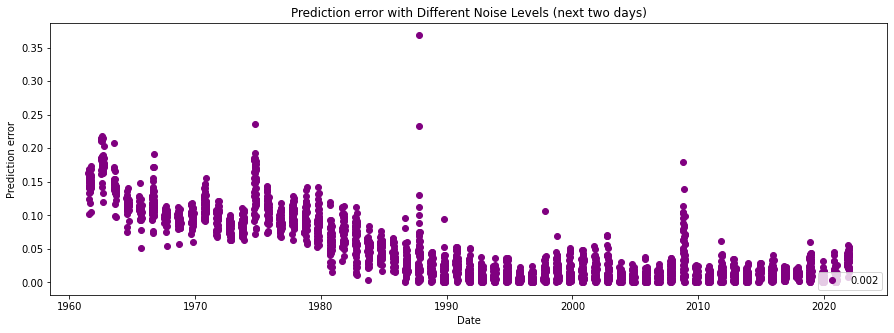

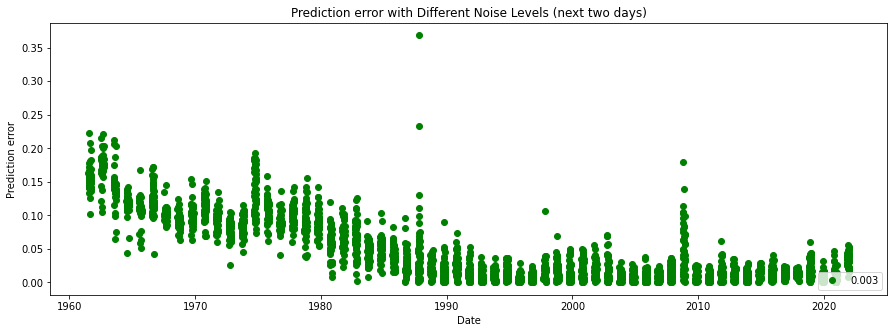

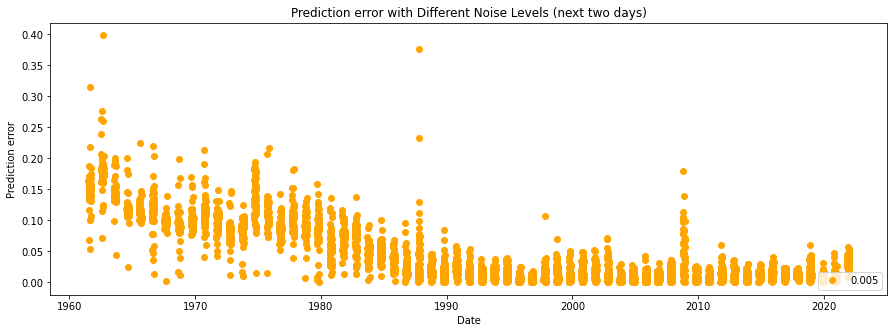

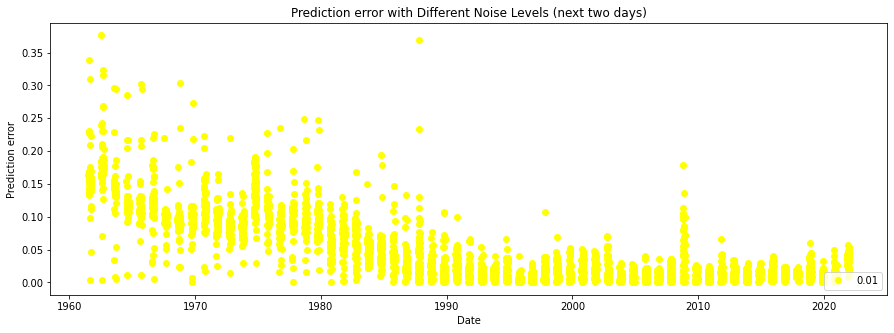

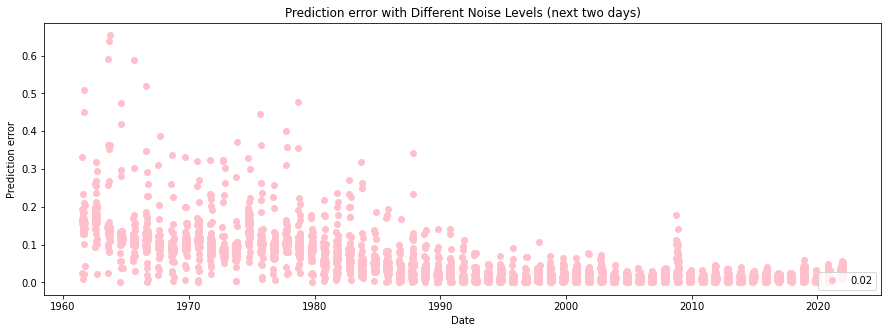

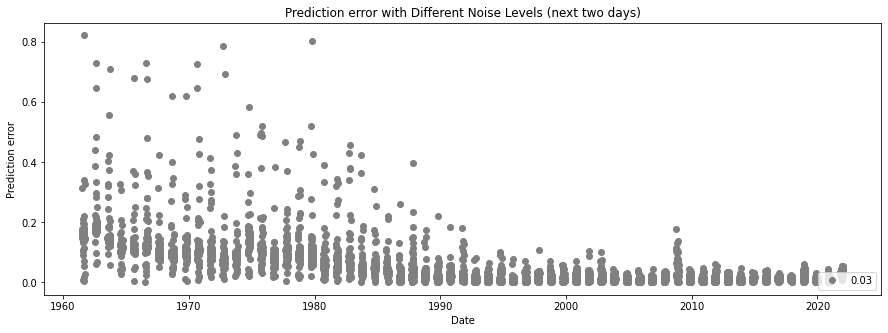

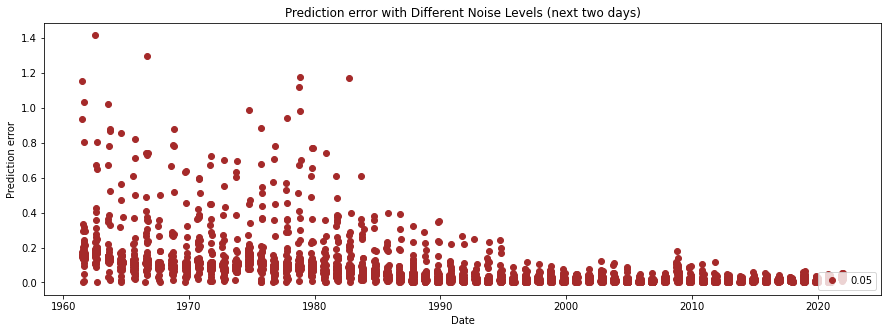

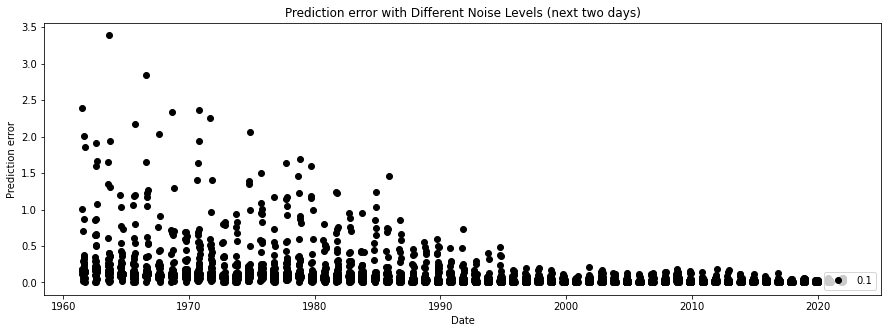

In [77]:
for i in range(len(std)): 
    plt.figure(1, figsize=(15, 5))
    plt.plot(date_test+ pd.Timedelta('1 day'), error_res_all[i], color=colors[i], lw=1, label = std[i], 
             marker= 'o', linestyle='None')  
    plt.xlabel('Date')
    plt.ylabel('Prediction error')
    plt.title('Prediction error with Different Noise Levels (next two days)')
    plt.legend(loc="lower right")  
    plt.show()

In [78]:
#predict next three days (idx = 2)
idx = 2
out_temp = np.concatenate( (Y_test[:, :, idx], Y_test[:, :, idx],Y_test[:, :, idx],Y_test[:, :, idx]), axis = 1)
target_test = scaler.inverse_transform(out_temp)[:, [0]]
error_res_all = []
for sigma in std:
    dataset_test_noise = NoiseData(X_test, sigma)
    test_inputs = Variable(torch.from_numpy(dataset_test_noise).float())
    output_test, _ = rnn_2(test_inputs)
    out_temp = np.concatenate((output_test.detach().numpy()[:, [idx]],
                               output_test.detach().numpy()[:, [idx]],
                               output_test.detach().numpy()[:, [idx]],
                               output_test.detach().numpy()[:, [idx]]), axis=1)
    predicted_price_test = scaler.inverse_transform(out_temp)[:, [0]]
    error = prediction_error(predicted_price_test,target_test)
    error_res_all.append(error.reshape(-1))

In [79]:
temp = date_test + pd.Timedelta('2 day')
labels = temp[:,0]
error_df=pd.DataFrame(error_res_all, columns=labels, index=std).T
error_df

0.001     0.002     0.003     0.005     0.010     0.020  \
1961-07-09  0.030237  0.030259  0.030145  0.029786  0.031369  0.032667   
1961-07-12  0.039908  0.058576  0.036591  0.011517  0.080091  0.363815   
1961-07-13  0.018454  0.017664  0.019111  0.017505  0.006722  0.030901   
1961-07-14  0.028533  0.029354  0.027495  0.027530  0.012512  0.018826   
1961-07-15  0.024217  0.020050  0.003417  0.010571  0.058711  0.062696   
...              ...       ...       ...       ...       ...       ...   
2022-01-07  0.063441  0.063446  0.063432  0.063459  0.063458  0.063417   
2022-01-08  0.056529  0.056529  0.056529  0.056529  0.056528  0.056529   
2022-01-09  0.064802  0.064802  0.064802  0.064802  0.064802  0.064802   
2022-01-12  0.082354  0.082353  0.082355  0.082348  0.082355  0.082371   
2022-01-13  0.088141  0.088141  0.088142  0.088141  0.088141  0.088140   

               0.030     0.050     0.100  
1961-07-09  0.032539  0.034204  0.035118  
1961-07-12  0.408946  0.554096  0.959357  
1961-07-13  0.039156  0.026980  0.125658  
1961-07-14  0.053281  0.017042  0.055661  
1961-07-15  0.096386  0.031726  0.154395  
...              ...       ...       ...  
2022-01-07  0.063568  0.063689  0.063404  
2022-01-08  0.056528  0.056528  0.056533  
2022-01-09  0.064802  0.064802  0.064802  
2022-01-12  0.082329  0.082346  0.082339  
2022-01-13  0.088143  0.088146  0.088150  

[3233 rows x 9 columns]

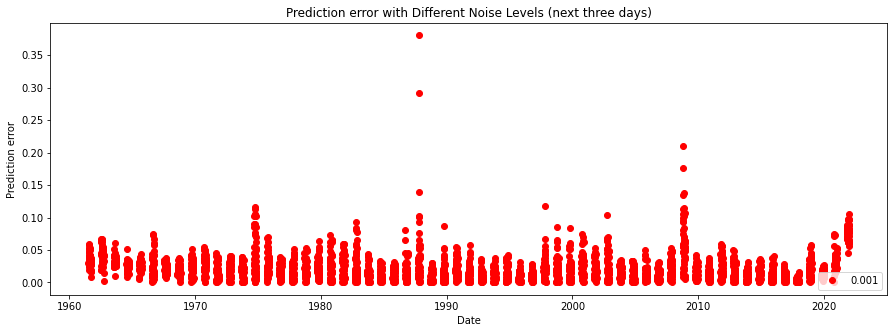

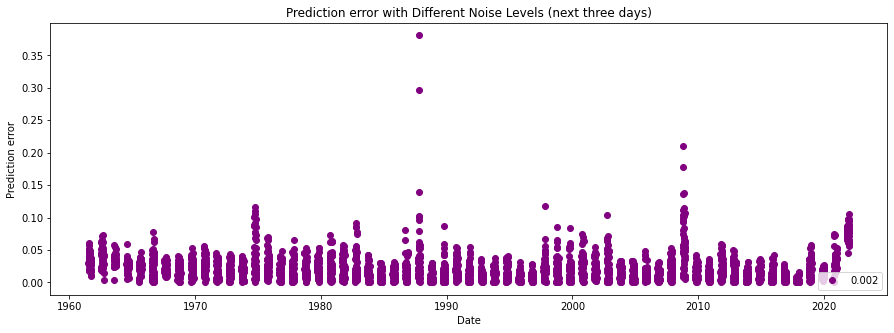

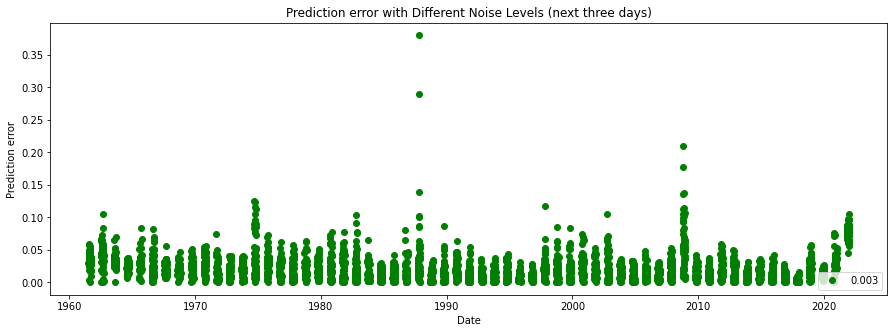

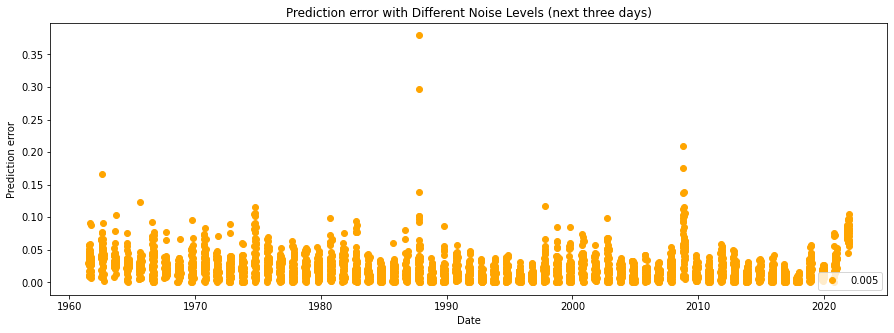

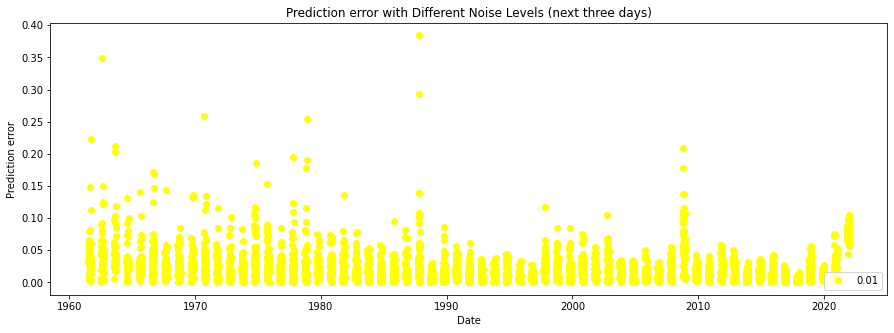

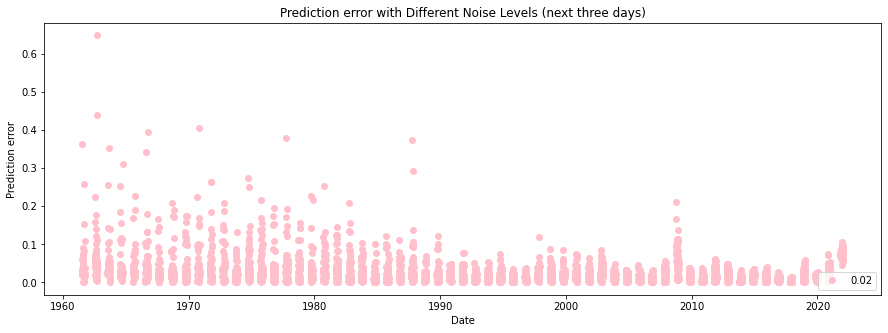

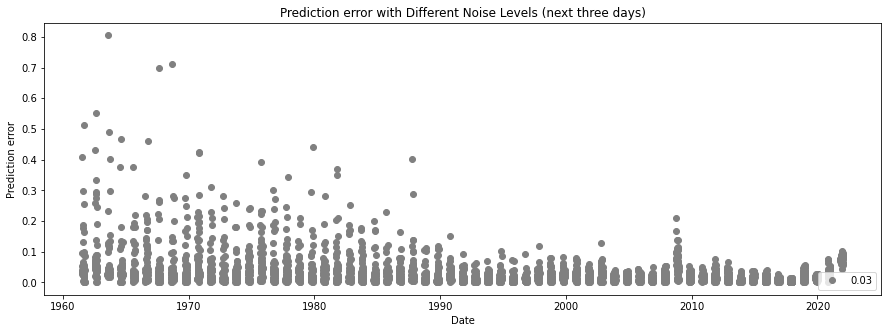

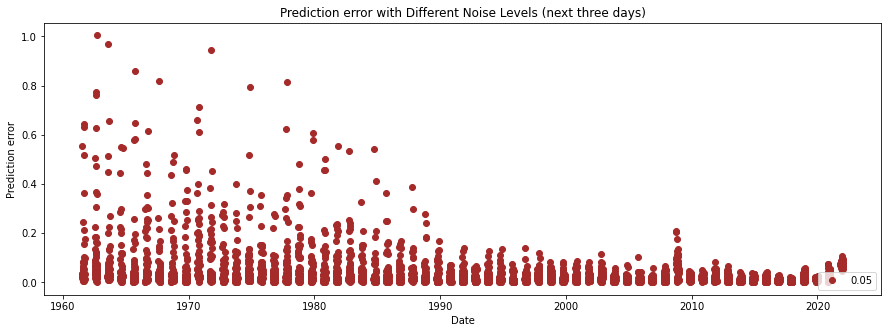

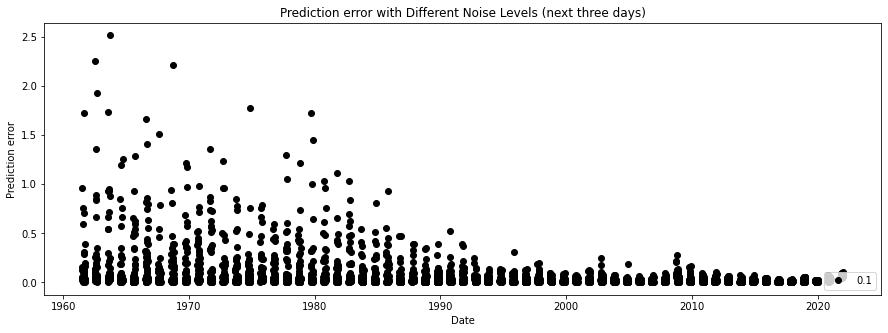

In [80]:
for i in range(len(std)): 
    plt.figure(1, figsize=(15, 5))
    plt.plot(date_test+ pd.Timedelta('2 day'), error_res_all[i], color=colors[i], lw=1, label = std[i], 
             marker= 'o', linestyle='None')  
    plt.xlabel('Date')
    plt.ylabel('Prediction error')
    plt.title('Prediction error with Different Noise Levels (next three days)')
    plt.legend(loc="lower right")  
    plt.show()

In [91]:
#predict next four days (idx = 3)
idx = 3
out_temp = np.concatenate( (Y_test[:, :, idx], Y_test[:, :, idx],Y_test[:, :, idx],Y_test[:, :, idx]), axis = 1)
target_test = scaler.inverse_transform(out_temp)[:, [0]]
error_res_all = []
for sigma in std:
    dataset_test_noise = NoiseData(X_test, sigma)
    test_inputs = Variable(torch.from_numpy(dataset_test_noise).float())
    output_test, _ = rnn_2(test_inputs)
    out_temp = np.concatenate((output_test.detach().numpy()[:, [idx]],
                               output_test.detach().numpy()[:, [idx]],
                               output_test.detach().numpy()[:, [idx]],
                               output_test.detach().numpy()[:, [idx]]), axis=1)
    predicted_price_test = scaler.inverse_transform(out_temp)[:, [0]]
    error = prediction_error(predicted_price_test,target_test)
    error_res_all.append(error.reshape(-1))

/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_40938/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target
/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_40938/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target
/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_40938/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target
/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_40938/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target
/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_40938/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target
/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_40938/1591607620.py:3: RuntimeWarning: divide by zero encount

In [92]:
temp = date_test + pd.Timedelta('3 day')
labels = temp[:,0]
error_df=pd.DataFrame(error_res_all, columns=labels, index=std).T
error_df

0.001     0.002     0.003     0.005     0.010     0.020  \
1961-07-10  0.260110  0.260195  0.260443  0.260588  0.260145  0.262391   
1961-07-13  0.273415  0.260106  0.312119  0.364466  0.309270  0.129594   
1961-07-14  0.250720  0.251697  0.249197  0.248506  0.249640  0.261250   
1961-07-15  0.254566  0.239292  0.279591  0.229405  0.248732  0.295732   
1961-07-16  0.260279  0.258410  0.265200  0.308391  0.139154  0.012896   
...              ...       ...       ...       ...       ...       ...   
2021-11-18  0.054447  0.054454  0.054399  0.054365  0.054546  0.054477   
2021-11-19  0.054140  0.054141  0.054140  0.054141  0.054141  0.054141   
2021-11-20  0.052501  0.052501  0.052501  0.052501  0.052501  0.052501   
2021-11-21  0.044717  0.044717  0.044717  0.044718  0.044717  0.044719   
2021-11-22  0.043552  0.043551  0.043552  0.043552  0.043552  0.043552   

               0.030     0.050     0.100  
1961-07-10  0.256284  0.266863  0.279940  
1961-07-13  0.610833  2.159211  0.676745  
1961-07-14  0.247830  0.261303  0.199098  
1961-07-15  0.140136  0.458808  0.509130  
1961-07-16  0.742548  1.279201  1.525677  
...              ...       ...       ...  
2021-11-18  0.054553  0.054360  0.055164  
2021-11-19  0.054139  0.054136  0.054145  
2021-11-20  0.052501  0.052501  0.052501  
2021-11-21  0.044716  0.044735  0.044733  
2021-11-22  0.043552  0.043547  0.043550  

[3233 rows x 9 columns]

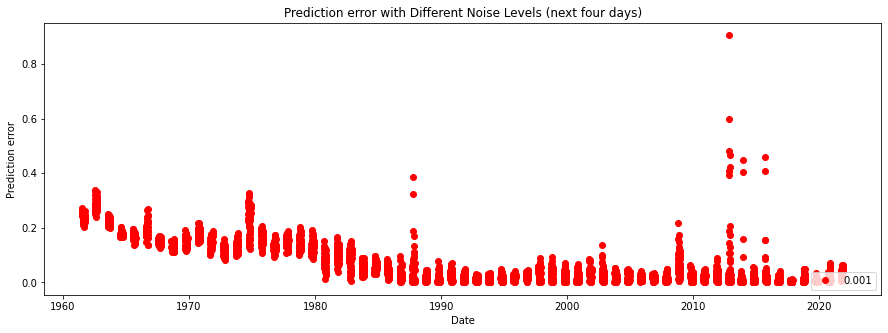

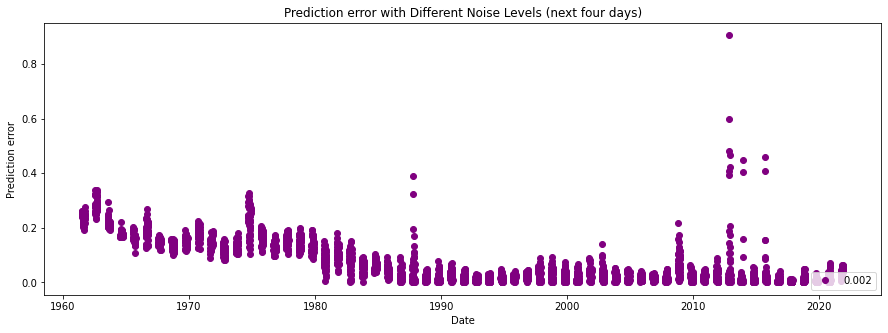

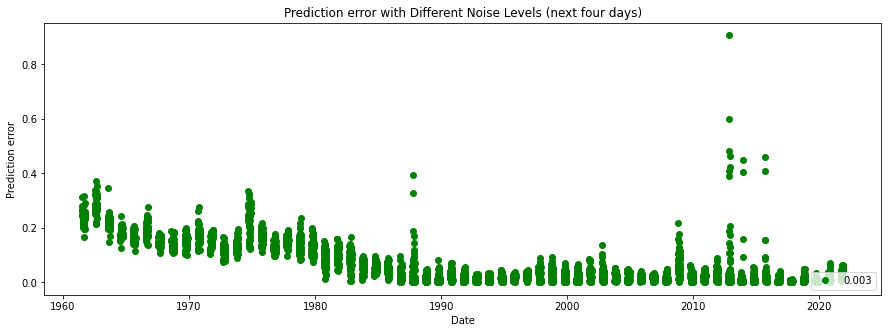

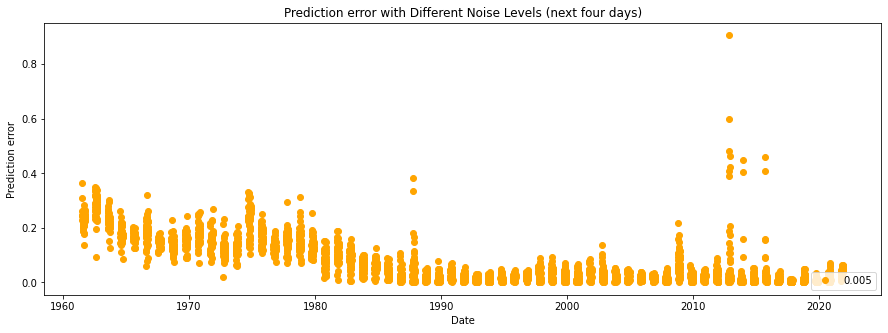

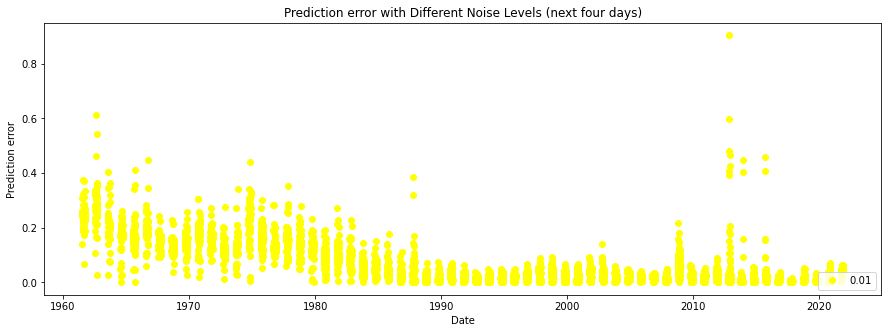

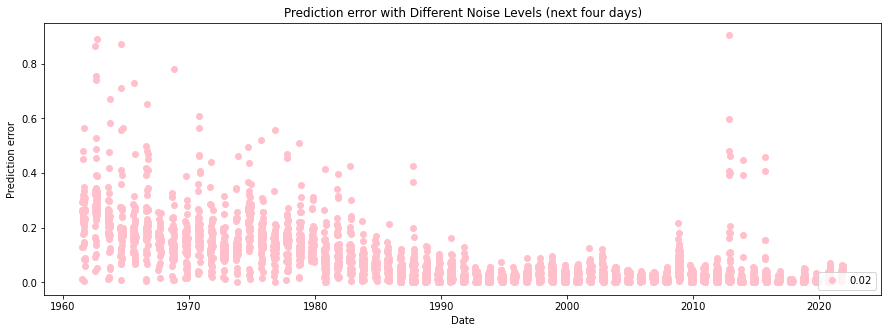

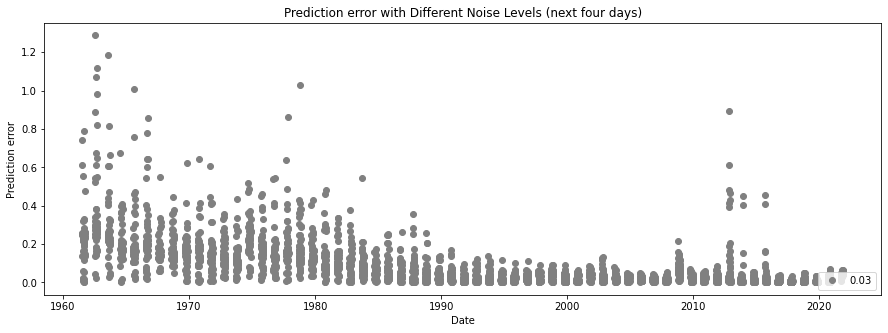

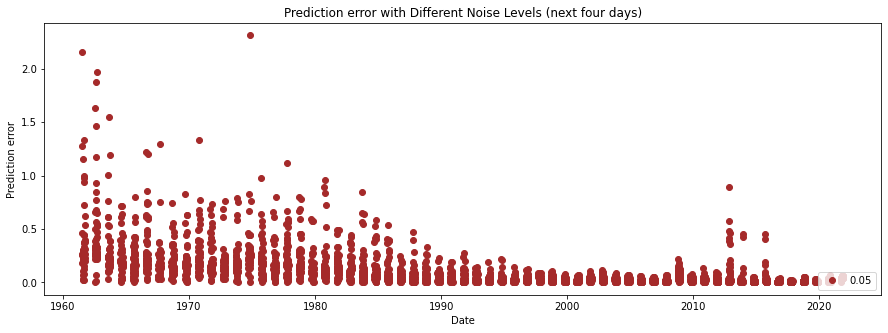

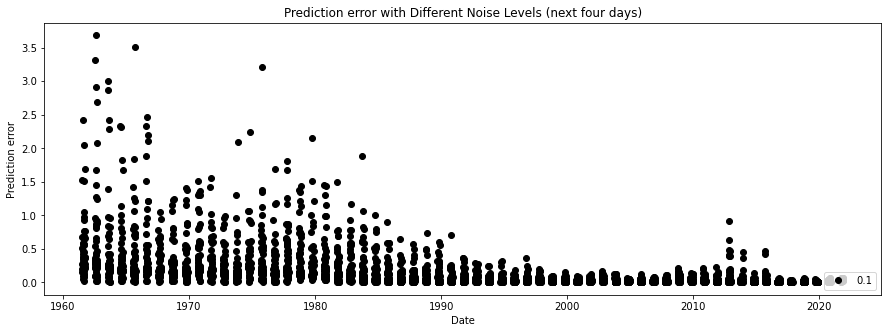

In [93]:
for i in range(len(std)): 
    plt.figure(1, figsize=(15, 5))
    plt.plot(date_test+ pd.Timedelta('3 day'), error_res_all[i], color=colors[i], lw=1, label = std[i], 
             marker= 'o', linestyle='None')  
    plt.xlabel('Date')
    plt.ylabel('Prediction error')
    plt.title('Prediction error with Different Noise Levels (next four days)')
    plt.legend(loc="lower right")  
    plt.show()

In [94]:
print("mean_train :", mean_train)
print("std_train :", std_train)
print("skewness_train", skewness_train)
print("kurtosis_train", kurtosis_train)

mean_train : [0.04111446313844052, 0.02509900541530061, 0.02817862109059389, 0.06666682629694655, 0.030509877137657352, 0.06483325116131934, 0.052799321885251264, 0.03985206810012004]
std_train : [0.03802194920847429, 0.030651276458087354, 0.03242961467121725, 0.06513820205740739, 0.04315515928502206, 0.08943953620002712, 0.05280758892245878, 0.05581359925126591]
skewness_train [3.5138780724724383, 9.233294177133478, 6.542090291949788, 1.7628268595989465, 7.534260935635216, 2.320652895430166, 1.841584278182403, 3.303164824206889]
kurtosis_train [20.210457948693648, 120.54113817570042, 63.27258603557941, 2.827459212465749, 69.62150160164053, 5.326557499207739, 3.3496256717386084, 16.087292420311886]


In [95]:
print("mean_test :", mean_test)
print("std_test :", std_test)
print("skewness_test", skewness_test)
print("kurtosis_test", kurtosis_test)

mean_test : [0.039908962774552824, 0.025365073498181484, 0.02886301630838713, 0.0635803188838095, 0.02120518070485796, 0.05497144271290803, 0.032964637580698536, 0.03289527607947593]
std_test : [0.03460711635067549, 0.029436615857675315, 0.03350539826645522, 0.0641107627553331, 0.04076735941611334, 0.06710381792336596, 0.04177011630350684, 0.04680359321355646]
skewness_test [4.436646859720553, 9.677721149853886, 7.824978808219696, 1.8403960468205613, 12.029669231637154, 3.921155462698012, 4.963077167052979, 7.042304653572083]
kurtosis_test [45.04138064910917, 145.68352126203362, 106.30290103160645, 4.140818267279078, 208.34700204442413, 30.838670921997803, 46.087357705222004, 86.5103172111884]
